# Análisis exploratorio de datos EDA
## Importar bibliotecas

In [63]:
# Librerías para Scraping
import requests
import gzip
import shutil
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import timedelta, date
import math
from pathlib import Path

# Librerías de Normalización y Limpieza
import pandas as pd
import numpy as np
import re
from unidecode import unidecode

# Librerías para Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from IPython.display import Image, display

# Modelado y Procesamiento
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


## Scraping de Datos de la Web `data.buenosaires.gob.ar`

In [2]:


class DatasetDownloader:
    def __init__(self, base_url, download_folder):
        self.base_url = base_url
        self.download_folder = Path(download_folder)
        # Make sure the download directory exists
        self.download_folder.mkdir(parents=True, exist_ok=True)

    def scrape_siniestros_urls(self):
        response = requests.get(self.base_url)
        soup = BeautifulSoup(response.content, 'html.parser')
        links = soup.find_all('a')

        file_urls = {}
        for link in links:
            href = link.get('href')
            if href and href.endswith(('.zip', '.xlsx', '.csv', '.gz', '.geojson', '.pdf')):
                file_name = href.split('/')[-1]
                file_urls[file_name] = href
        return file_urls

    def download_file(self, url, save_path):
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Archivo guardado: {save_path}")
        except Exception as e:
            print(f"Error al descargar el archivo: {url}")
            print(f"Error details: {e}")

    def download_datasets(self):
        file_urls_dict = self.scrape_siniestros_urls()
        for file_name, url in file_urls_dict.items():
            save_path = self.download_folder / file_name
            self.download_file(url, save_path)

# Example usage
base_url = 'https://data.buenosaires.gob.ar/dataset/victimas-siniestros-viales'

base_url2 = 'https://data.buenosaires.gob.ar/dataset/comunas'

download_folder = '../datasets/raw'
downloader = DatasetDownloader(base_url, download_folder)
downloader.download_datasets()
downloader = DatasetDownloader(base_url2, download_folder)
downloader.download_datasets()
base_url =  'https://data.buenosaires.gob.ar/dataset/informacion-censal-por-radio'
download_folder = '../datasets/raw'
downloader = DatasetDownloader(base_url, download_folder)
downloader.download_datasets()

Archivo guardado: ..\datasets\raw\lesiones.xlsx
Archivo guardado: ..\datasets\raw\homicidios.xlsx
Archivo guardado: ..\datasets\raw\NOTAS_LESIONES_SINIESTRO_VIAL.pdf
Archivo guardado: ..\datasets\raw\NOTAS_HOMICIDIOS_SINIESTRO_VIAL.pdf
Archivo guardado: ..\datasets\raw\comunas.csv
Archivo guardado: ..\datasets\raw\comunas.xlsx
Archivo guardado: ..\datasets\raw\comunas.zip
Archivo guardado: ..\datasets\raw\comunas.geojson
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2010.csv
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2010.xlsx
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2010.zip
Archivo guardado: ..\datasets\raw\caba_radios_censales.geojson
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2001.csv
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2001.xlsx
Archivo guardado: ..\datasets\raw\informacion-censal-por-radio-2001.zip


## Importación de Datos Directorio `../datasets/raw` 

In [2]:
homicidios = pd.read_excel('../datasets/raw/homicidios.xlsx',sheet_name = 'HECHOS', engine='openpyxl')
victima_h = pd.read_excel('../datasets/raw/homicidios.xlsx',sheet_name = 'VICTIMAS',  engine='openpyxl')
comunas_h = pd.read_excel('../datasets/raw/comunas.xlsx' , sheet_name = 'comunas',  engine='openpyxl')
censo_r = pd.read_csv('../datasets/raw/informacion-censal-por-radio-2010.csv')
# Asignación de Nombres personalizados a Datframes
homicidios.name = 'homicidios'
victima_h.name = 'victima_h'
comunas_h.name = 'comunas_h'
censo_r.name = 'censo_r'


In [3]:
pd.set_option('display.max_columns', None)
dataframes = [homicidios, victima_h, comunas_h, censo_r]

## Análisis exploratorio de datos EDA
#### Exploración de Moda, Mediana, Media de cada Tablas `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.

In [4]:
def calculate_statistics(df):
    print(f"Estadísticas para el DataFrame {df.name}:\n")
    
    for column in df.columns:
        unique_values = df[column].unique()
        
        # Verificar si la columna es de tipo objeto (cadena)
        if pd.api.types.is_object_dtype(df[column]):
            # Filtrar valores largos
            unique_values_filtered = [value if len(str(value)) < 50 else 'Valor largo' for value in unique_values]
        else:
            unique_values_filtered = unique_values
        
        print(f"Columna: {column}, Valores únicos: {unique_values_filtered[:5]}")
        
        if pd.api.types.is_numeric_dtype(df[column]):
            print(f"Media: {df[column].mean()}")
            print(f"Mediana: {df[column].median()}")
        elif pd.api.types.is_object_dtype(df[column]):
            # Obtener la moda
            mode_value = df[column].mode().iloc[0]
            # Verificar la longitud de la moda
            mode_display = mode_value if len(str(mode_value)) < 50 else 'Valor largo'
            print(f"Moda: {mode_display}")
        
        print("\n")

# Ejemplo de uso:
for df in dataframes:
    calculate_statistics(df)
    print("\n\n")


Estadísticas para el DataFrame homicidios:

Columna: ID, Valores únicos: ['2016-0001', '2016-0002', '2016-0003', '2016-0004', '2016-0005']
Moda: 2016-0001


Columna: N_VICTIMAS, Valores únicos: [1 2 3]
Media: 1.0301724137931034
Mediana: 1.0


Columna: FECHA, Valores únicos: <DatetimeArray>
['2016-01-01 00:00:00', '2016-01-02 00:00:00', '2016-01-03 00:00:00',
 '2016-01-10 00:00:00', '2016-01-21 00:00:00']
Length: 5, dtype: datetime64[ns]


Columna: AAAA, Valores únicos: [2016 2017 2018 2019 2020]
Media: 2018.1882183908046
Mediana: 2018.0


Columna: MM, Valores únicos: [1 2 3 4 5]
Media: 6.692528735632184
Mediana: 7.0


Columna: DD, Valores únicos: [ 1  2  3 10 21]
Media: 15.936781609195402
Mediana: 16.0


Columna: HORA, Valores únicos: [datetime.time(4, 0), datetime.time(1, 15), datetime.time(7, 0), datetime.time(0, 0), datetime.time(5, 20)]
Moda: 14:00:00


Columna: HH, Valores únicos: [4, 1, 7, 0, 5]
Moda: 7


Columna: LUGAR_DEL_HECHO, Valores únicos: ['AV PIEDRA BUENA Y AV FERNANDEZ 

### Análisis de Valores de cada Tablas `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.
- Si Dataframe no está en el listado de Valores Nulos, se asume información Completa 

In [5]:
#dataframes = [homicidios, victima_h, comunas_h, lesiones, victima_l]

# Crear un DataFrame para almacenar la información sobre valores raros
reg_valores_raros = pd.DataFrame(columns=['Nombre DataFrame', 'Nombre Columna', 'Tipo de Dato', 'Total Valores', 'Total Nulos', 'Total Raros', 'Valores Faltantes %'])

# Definir qué valores consideras "raros"
valores_raros = ['SD', 'No especificado', 'sd' , '', 'Point (. .)']

# Iterar sobre cada DataFrame
for df in dataframes:
    # Iterar sobre cada columna del DataFrame
    for columna in df.columns:
        # Obtener información de cada columna
        nombre_df = df.name
        nombre_columna = columna
        tipo_dato = df[columna].dtype
        total_valores = len(df)
        total_nulos = df[columna].isnull().sum()
        total_raros = df[columna].isin(valores_raros).sum()
        total_nulos_y_raros = total_nulos + total_raros
        porcentaje_raros = ((total_nulos + total_raros )/ total_valores) * 100

        # Agregar la información al DataFrame de resumen
        reg_valores_raros.loc[len(reg_valores_raros)] = [nombre_df, nombre_columna, tipo_dato, total_valores, total_nulos, total_raros,  porcentaje_raros]

# Filtrar el DataFrame para mostrar solo las filas con 'Total Raros' mayor que cero
reg_valores_raros_c = reg_valores_raros[reg_valores_raros['Valores Faltantes %'] > 0]


"""
# Contar los valores únicos y su frecuencia en la columna 'GRAVEDAD'
conteo_gravedad = victima_l['GRAVEDAD'].value_counts()
# Mostrar el resultado
print(conteo_gravedad)
"""
# Ordenar el DataFrame por 'Valores Faltantes %' de forma descendente
reg_valores_raros_c = reg_valores_raros_c.sort_values(by='Valores Faltantes %', ascending=False)

# Mostrar el DataFrame ordenado
reg_valores_raros_c.head(50)

Nombre DataFrame         Nombre Columna Tipo de Dato  Total Valores  \
11       homicidios                 Altura      float64            696   
12       homicidios                  Cruce       object            696   
30        victima_h    FECHA_FALLECIMIENTO       object            717   
29        victima_h                   EDAD       object            717   
20       homicidios                ACUSADO       object            696   
15       homicidios              XY (CABA)       object            696   
26        victima_h                    ROL       object            717   
19       homicidios                VICTIMA       object            696   
27        victima_h                VICTIMA       object            717   
13       homicidios  Dirección Normalizada       object            696   
28        victima_h                   SEXO       object            717   
6        homicidios                   HORA       object            696   
7        homicidios                     HH       object            696   
8        homicidios        LUGAR_DEL_HECHO       object            696   
10       homicidios                  Calle       object            696   

    Total Nulos  Total Raros  Valores Faltantes %  
11          567            0            81.465517  
12          171            0            24.568966  
30            0           68             9.483961  
29            0           53             7.391911  
20            0           23             3.304598  
15            0           14             2.011494  
26            0           11             1.534170  
19            0            9             1.293103  
27            0            9             1.255230  
13            8            0             1.149425  
28            0            6             0.836820  
6             0            1             0.143678  
7             0            1             0.143678  
8             0            1             0.143678  
10            1            0             0.143678

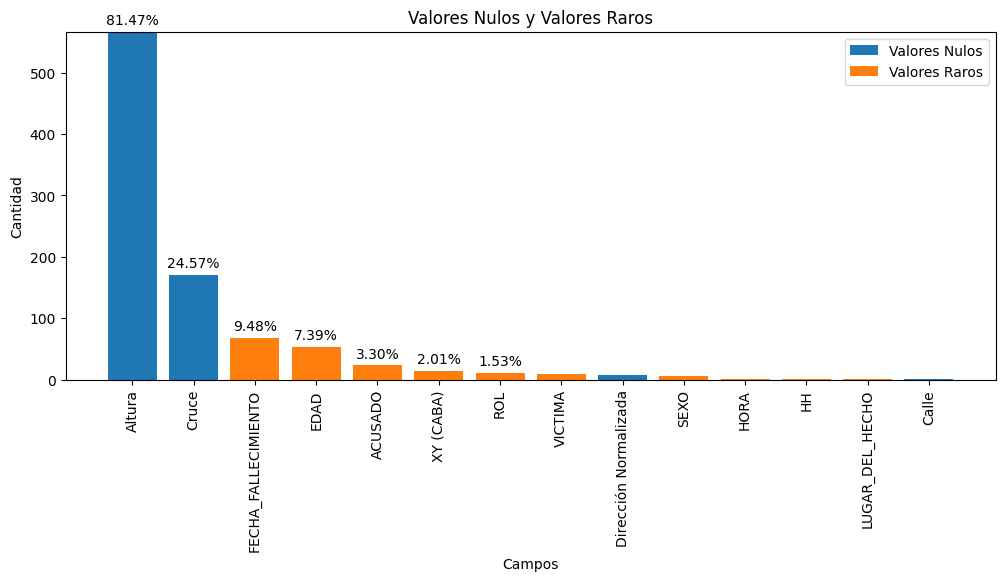

In [6]:
# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar barras apiladas para valores nulos y raros
barras = ax.bar(reg_valores_raros_c['Nombre Columna'], reg_valores_raros_c['Total Nulos'], label='Valores Nulos')
barras_raros = ax.bar(reg_valores_raros_c['Nombre Columna'], reg_valores_raros_c['Total Raros'], bottom=reg_valores_raros_c['Total Nulos'], label='Valores Raros')

# Configurar etiquetas y título
ax.set_xlabel('Campos')
ax.set_ylabel('Cantidad')
ax.set_title('Valores Nulos y Valores Raros')

# Rotar las etiquetas del eje x
plt.xticks(rotation=90)

# Agregar leyenda
ax.legend()

# Ajustar el espaciado entre subgráficos
plt.subplots_adjust(bottom=0.3)

# Obtener las 7 barras más altas
alturas_barras = [bar.get_height() for bar in barras]
alturas_barras_raros = [bar.get_height() for bar in barras_raros]
alturas_totales = [x + y for x, y in zip(alturas_barras, alturas_barras_raros)]
indices_mayores = sorted(range(len(alturas_totales)), key=lambda x: alturas_totales[x], reverse=True)[:7]

# Agregar etiquetas con porcentajes a las 7 barras más altas
for i, indice in enumerate(indices_mayores):
    altura_total = alturas_totales[indice]
    porcentaje = altura_total / reg_valores_raros_c['Total Valores'].iloc[indice] * 100
    ax.text(indice, altura_total + 0.01 * reg_valores_raros_c['Total Valores'].max(), f"{porcentaje:.2f}%", ha='center', va='bottom')

# Mostrar el gráfico
plt.show()

### PreProcesamiento de Columnas de las Tablas `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.

In [7]:
# Función para limpiar y formatear los nombres de las columnas
def limpiar_nombre(nombre):
    # Eliminar caracteres especiales y espacios
    nombre = re.sub(r'\W+', '_', nombre)
    # Eliminar acentos
    nombre = unidecode(nombre)
    # Convertir a minúsculas
    nombre = nombre.lower()
    return nombre

def limpiar_nombres_columnas(df):
    df.columns = [limpiar_nombre(col) for col in df.columns]

# Aplicar la función limpiar_nombres_columnas a cada DataFrame
for df in dataframes:
    limpiar_nombres_columnas(df)

# Imprimir los nombres de las columnas limpias para cada DataFrame
for df in dataframes:
    print(f"Columnas de {df.name}:")
    print(df.columns)
    print()

Columnas de homicidios:
Index(['id', 'n_victimas', 'fecha', 'aaaa', 'mm', 'dd', 'hora', 'hh',
       'lugar_del_hecho', 'tipo_de_calle', 'calle', 'altura', 'cruce',
       'direccion_normalizada', 'comuna', 'xy_caba_', 'pos_x', 'pos_y',
       'participantes', 'victima', 'acusado'],
      dtype='object')

Columnas de victima_h:
Index(['id_hecho', 'fecha', 'aaaa', 'mm', 'dd', 'rol', 'victima', 'sexo',
       'edad', 'fecha_fallecimiento'],
      dtype='object')

Columnas de comunas_h:
Index(['id', 'objeto', 'comunas', 'barrios', 'perimetro', 'area'], dtype='object')

Columnas de censo_r:
Index(['wkt', 'id', 'co_frac_ra', 'comuna', 'fraccion', 'radio', 'total_pob',
       't_varon', 't_mujer', 't_vivienda', 'v_particul', 'v_colectiv',
       't_hogar', 'h_con_nbi', 'h_sin_nbi'],
      dtype='object')



### PreProcesamiento de Valores Faltantes de las Tablas `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.
- Revisamos diferentes caracteres para representar los valores faltantes, lo cual se representa un indicador de normalización previa, sin embargo, para mejorar el dato se normalizara todos los valores faltantes a tipo nan para que en posteriores análisis se evalue y considere la porción de datos faltantes.

In [8]:
def reemplazar_nulos_y_raros(dataframes, valores_raros):
    dataframes_limpios = []

    for df in dataframes:
        # Reemplazar los valores raros con NaN
        df = df.replace(valores_raros, pd.NaT)

        # Reemplazar los valores nulos con NaN
        df = df.replace('', pd.NaT)

        dataframes_limpios.append(df)

    return dataframes_limpios

dataframes = [homicidios, victima_h, comunas_h, censo_r]
# Definir qué valores consideras "raros"
valores_raros = ['SD', 'No especificado', 'sd' , '']
# Ejemplo de uso
# Supongamos que tienes una lista de DataFrames llamada 'dataframes' y 'valores_raros' es la lista de valores raros
dataframes_limpios = reemplazar_nulos_y_raros(dataframes, valores_raros)

# Puedes asignar cada DataFrame tratado a una variable separada
homicidios_l, victima_h_l, comunas_h_l, censo_r_l = dataframes_limpios.copy()

### PreProcesamiento de Tabla `homicidos`

In [9]:
def procesar_dataframe(df):
    # Convertir la columna de fecha a datetime
    df['fecha'] = pd.to_datetime(df['fecha'])

    # Crear nuevas columnas para año, mes y día
    df['anio'] = df['fecha'].dt.year
    df['mes'] = df['fecha'].dt.month
    df['dia'] = df['fecha'].dt.day

    # Llenar los valores nulos en 'hora' con '00:00:00'
    df['hora'] = df['hora'].fillna('00:00:00')


    # Convertir 'hora' a formato datetime
    df['hora'] = pd.to_datetime(df['hora'], format='%H:%M:%S')

    # Crear una nueva columna para fecha y hora combinadas
    df['fecha_hora'] = pd.to_datetime(dict(
        year=df['anio'],
        month=df['mes'],
        day=df['dia'],
        hour=df['hora'].dt.hour,
        minute=df['hora'].dt.minute
    ))

    # Eliminar columnas innecesarias
    columns_to_drop = ['fecha', 'aaaa', 'mm', 'dd', 'hh','hora','altura']
    df = df.drop(columns=columns_to_drop)

    # Crear columnas formateadas para fecha y hora
    df['fecha_formato'] = df['fecha_hora'].dt.strftime('%Y-%m-%d')
    df['hora_formato'] = df['fecha_hora'].dt.strftime('%H:%M')
    df['hora_i'] = df['fecha_hora'].dt.strftime('%H')
    df['hora_i'] = df['hora_i'].astype('int')

    return df

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'df'
homicidios_l = procesar_dataframe(homicidios_l.copy())


In [10]:
def procesar_homicidios_l(df):
    
    # Seleccionar todas las columnas de tipo objeto
    columnas_objeto = df.select_dtypes(include=['object']).columns
    
    # Reemplazar los valores NaN con "SRE" en las columnas seleccionadas
    df[columnas_objeto] = df[columnas_objeto].fillna("SNR")
    
    return df

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'victima_h_l'
homicidios_l = procesar_homicidios_l(homicidios_l.copy())

In [11]:
def procesar_homicidios_l(df):
    valid_positions = ~(df['pos_x'].str.contains('[^0-9.,-]') | df['pos_y'].str.contains('[^0-9.,-]') | (df['pos_x'] == '.') | (df['pos_y'] == '.'))

    # Establecer posiciones no válidas en NaN
    df.loc[~valid_positions, ['pos_x', 'pos_y']] = np.nan

    # Convertir las cadenas a tipo numérico (float)
    df['pos_x'] = df['pos_x'].str.replace(',', '.').astype(float)
    df['pos_y'] = df['pos_y'].str.replace(',', '.').astype(float)
    # Supongamos que tu DataFrame se llama df
    df.rename(columns={'pos_x': 'longitud', 'pos_y': 'latitud'}, inplace=True)
    return df
def extraer_coordenadas(texto):
    # Utilizamos una expresión regular para extraer las coordenadas
    coordenadas = re.findall(r'\d+\.\d+', texto)
    if len(coordenadas) == 2:
        return float(coordenadas[0]), float(coordenadas[1])
    else:
        return None, None

homicidios_lm = procesar_homicidios_l(homicidios_l)
# Aplicar la función a la columna 'XY (CABA)'
homicidios_lm['coordenada_x'], homicidios_lm['coordenada_y'] = zip(*homicidios_lm['xy_caba_'].map(extraer_coordenadas))

# Eliminar columnas innecesarias
columns_to_drop = ['xy_caba_', 'calle','cruce','participantes', 'victima']
homicidios_lm = homicidios_lm.drop(columns=columns_to_drop)



In [12]:
homicidios_lm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     696 non-null    object        
 1   n_victimas             696 non-null    int64         
 2   lugar_del_hecho        696 non-null    object        
 3   tipo_de_calle          696 non-null    object        
 4   direccion_normalizada  696 non-null    object        
 5   comuna                 696 non-null    int64         
 6   longitud               684 non-null    float64       
 7   latitud                684 non-null    float64       
 8   acusado                696 non-null    object        
 9   anio                   696 non-null    int32         
 10  mes                    696 non-null    int32         
 11  dia                    696 non-null    int32         
 12  fecha_hora             696 non-null    datetime64[ns]
 13  fecha

### PreProcesamiento de Tabla `victima_l`

In [13]:
def procesar_victima_h_l(df):
    # Llenar los valores nulos en 'fecha_fallecimiento' con 'fecha' + 7 días
    df['fecha_fallecimiento'] = df['fecha_fallecimiento'].combine_first(df['fecha'] + pd.DateOffset(days=7))
    
    df['edad'] = pd.to_numeric(df['edad'], errors='coerce')
    
    # Llenar los valores nulos en 'edad' con -1
    df['edad'] = df['edad'].fillna(-1)
    
    # Filtrar valores no negativos en 'edad' y luego convertir a entero
    df['edad'] = np.where((df['edad'] >= 0), df['edad'].astype(int), -1)

  
    # Seleccionar todas las columnas de tipo objeto
    columnas_objeto = df.select_dtypes(include=['object']).columns
    
    # Reemplazar los valores NaN con "SRE" en las columnas seleccionadas
    df[columnas_objeto] = df[columnas_objeto].fillna("SNR")
    
    # Eliminar columnas innecesarias
    columns_to_drop = ['fecha', 'aaaa', 'mm', 'dd']
    df2 = df.drop(columns=columns_to_drop)
    
    # Llenar los valores nulos en 'hora' con '00:00:00'
    df2['fecha_fallecimiento'] = df2['fecha_fallecimiento'].fillna('2018-09-21 00:00:00')
    df2['fecha_fallecimiento'] = pd.to_datetime(df2['fecha_fallecimiento'])

    return df2

# Ejemplo de uso:
# Supongamos que tu DataFrame se llama 'victima_h_l'
victima_h_lm = procesar_victima_h_l(victima_h_l.copy())


In [14]:
victima_h_lm.head(5)

id_hecho        rol victima       sexo  edad fecha_fallecimiento
0  2016-0001  CONDUCTOR    MOTO  MASCULINO    19          2016-01-01
1  2016-0002  CONDUCTOR    AUTO  MASCULINO    70          2016-01-02
2  2016-0003  CONDUCTOR    MOTO  MASCULINO    30          2016-01-03
3  2016-0004  CONDUCTOR    MOTO  MASCULINO    18          2016-01-17
4  2016-0005  CONDUCTOR    MOTO  MASCULINO    29          2016-02-01

In [15]:
victima_h_lm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_hecho             717 non-null    object        
 1   rol                  717 non-null    object        
 2   victima              717 non-null    object        
 3   sexo                 717 non-null    object        
 4   edad                 717 non-null    int32         
 5   fecha_fallecimiento  717 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(4)
memory usage: 30.9+ KB


In [16]:
victima_h_lm.edad.unique()

array([19, 70, 30, 18, 29, 22, 16, 59, 65, 34, 41, 50, 38, 21, 52, 36, 20,
       54, -1, 56, 24, 78, 79, 26, 57, 37, 58, 23, 60, 42, 53, 51, 40, 87,
       76, 75, 35, 80, 43, 45, 67, 27, 55, 49, 81, 25, 33, 46, 83, 39, 28,
        7, 48,  4, 82, 32, 17, 47, 61, 10, 95, 73, 84, 66, 85,  1, 15, 13,
       77, 44, 31, 62, 74, 71, 11, 86, 69, 72, 12, 63, 92, 68, 91, 64,  5,
       88])

### Estadística Descriptiva  `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.
- Revisamos diferentes valores para representar los estadístcos clave para cada modelo de datos de forma inicial previa
al modelo de ETL

In [17]:
dataNumericas = homicidios_lm.select_dtypes(include=['number']) 
dataNumericas.describe()

n_victimas      comuna    longitud     latitud         anio  \
count  696.000000  696.000000  684.000000  684.000000   696.000000   
mean     1.030172    7.425287  -58.441545  -34.619632  2018.188218   
std      0.179393    4.387050    0.046144    0.035289     1.683754   
min      1.000000    0.000000  -58.529942  -34.705250  2016.000000   
25%      1.000000    4.000000  -58.476218  -34.643689  2017.000000   
50%      1.000000    8.000000  -58.444513  -34.622928  2018.000000   
75%      1.000000   11.000000  -58.401841  -34.596799  2020.000000   
max      3.000000   15.000000  -58.356082  -34.534654  2021.000000   

              mes         dia      hora_i   coordenada_x   coordenada_y  
count  696.000000  696.000000  696.000000     682.000000     682.000000  
mean     6.692529   15.935345   11.640805  101990.962338  101078.485362  
std      3.571309    8.641883    6.709834    4230.329590    3914.622909  
min      1.000000    1.000000    0.000000   93889.867899   91571.233073  
25%      4.000000    9.000000    6.000000   98807.750321   98407.889777  
50%      7.000000   16.000000   11.000000  101721.590022  100708.189095  
75%     10.000000   23.000000   17.250000  105630.884244  103634.991834  
max     12.000000   31.000000   23.000000  109831.098614  110496.053085

In [18]:
dataNumericas2 = victima_h_lm.select_dtypes(include=['number']) 
dataNumericas2.describe()

edad
count  717.000000
mean    38.976290
std     22.143154
min     -1.000000
25%     24.000000
50%     35.000000
75%     55.000000
max     95.000000

In [19]:
dataNumericas3 = comunas_h_l.select_dtypes(include=['number']) 
dataNumericas3.describe()

id    comunas     perimetro          area
count  15.000000  15.000000     15.000000  1.500000e+01
mean    8.000000   8.000000  20587.190459  1.360458e+07
std     4.472136   4.472136   7510.793844  5.193868e+06
min     1.000000   1.000000  10486.260809  6.317265e+06
25%     4.500000   4.500000  17532.387476  9.636965e+06
50%     8.000000   8.000000  19987.696155  1.432290e+07
75%    11.500000  11.500000  21789.685253  1.617559e+07
max    15.000000  15.000000  36102.201573  2.221690e+07

In [20]:
dataNumericas4 = censo_r_l.select_dtypes(include=['number']) 
dataNumericas4.describe()

id       comuna     fraccion        radio    total_pob  \
count  3554.000000  3554.000000  3554.000000  3554.000000  3554.000000   
mean   1777.500000     8.007597    12.375633     5.838773   813.210748   
std    1026.095756     4.540923     7.364758     3.349121   292.823849   
min       1.000000     1.000000     1.000000     1.000000     0.000000   
25%     889.250000     4.000000     6.000000     3.000000   646.250000   
50%    1777.500000     8.000000    12.000000     6.000000   786.000000   
75%    2665.750000    12.000000    18.000000     8.000000   928.000000   
max    3554.000000    15.000000    31.000000    23.000000  3945.000000   

           t_varon      t_mujer   t_vivienda   v_particul   v_colectiv  \
count  3554.000000  3554.000000  3554.000000  3554.000000  3554.000000   
mean    374.136466   439.074282   401.361283   400.835959     0.525324   
std     143.546304   154.216231   142.250885   142.176408     1.089858   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%     294.000000   350.250000   311.250000   311.000000     0.000000   
50%     360.000000   425.000000   377.000000   377.000000     0.000000   
75%     428.000000   504.000000   462.000000   461.000000     1.000000   
max    2012.000000  1933.000000  1405.000000  1405.000000    14.000000   

           t_hogar    h_con_nbi    h_sin_nbi  
count  3554.000000  3554.000000  3554.000000  
mean    323.616770    19.351716   304.265053  
std     105.766922    32.329852   103.503040  
min       0.000000     0.000000     0.000000  
25%     259.000000     2.000000   242.000000  
50%     310.000000     6.000000   295.000000  
75%     371.000000    23.000000   352.000000  
max    1093.000000   403.000000  1052.000000

### Análisis de Outliers en  `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.
- Revisamos diferentes caracteres para representar los valores faltantes, lo cual se representa un indicador de normalización previa, sin embargo, para mejorar el dato se normalizara todos los valores faltantes a tipo nan para que en posteriores análisis se evalue y considere la porción de datos faltantes.

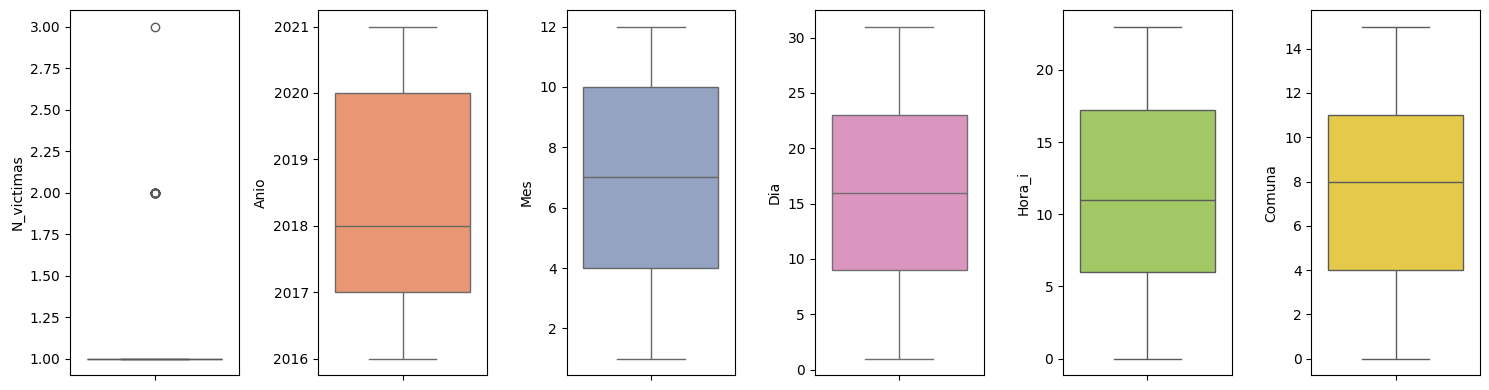

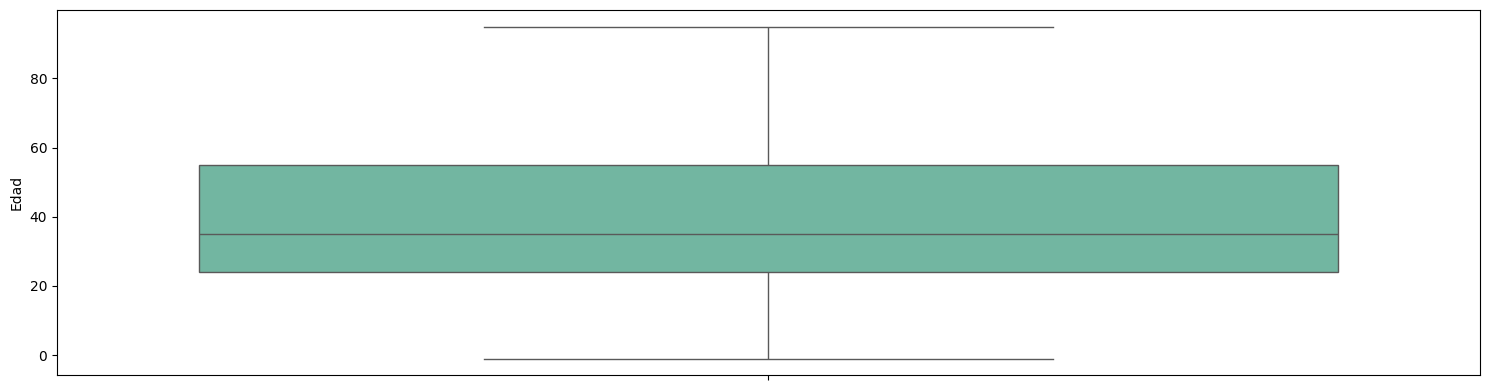

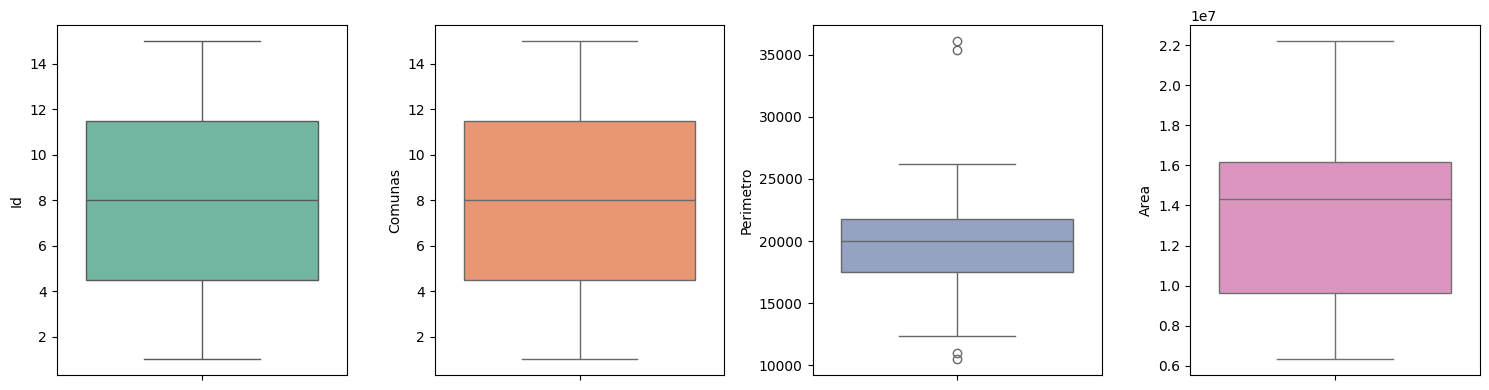

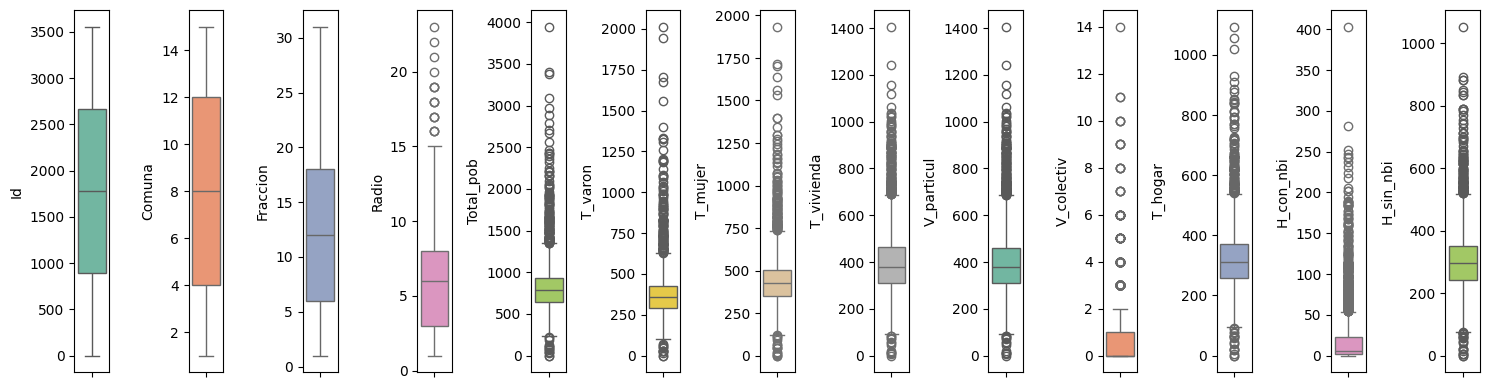

In [21]:
def plot_boxplots(df, numeric_vars, figsize=(15, 4)):
    # Ajustar el tamaño de la figura
    plt.figure(figsize=figsize)

    # Colores para los boxplots
    colors = sns.color_palette("Set2", n_colors=len(numeric_vars))

    # Crear subplots para los gráficos
    for i, variable in enumerate(numeric_vars, start=1):
        plt.subplot(1, len(numeric_vars), i)
        sns.boxplot(data=df, y=variable, color=colors[i-1])
        plt.ylabel(variable.capitalize())  # Añadir etiquetas en mayúsculas para mejor legibilidad

    # Ajustar espaciado entre subplots
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Ejemplo de uso con homicidios_lm
numeric_variables_homicidios = ['n_victimas', 'anio', 'mes', 'dia', 'hora_i', 'comuna']
plot_boxplots(homicidios_lm, numeric_variables_homicidios)

plot_boxplots(victima_h_lm, victima_h_lm.select_dtypes(include=['number']).columns)
plot_boxplots(comunas_h_l, comunas_h_l.select_dtypes(include=['number']).columns)
plot_boxplots(censo_r_l, censo_r_l.select_dtypes(include=['number']).columns)

##### 1. **Siniestros Fatales (homicidios_l):**
- **n_victimas:**
  - En promedio, hay alrededor de 1 víctima por homicidio.
  - La desviación estándar indica que la mayoría de los homicidios tienen una víctima, pero hay cierta variabilidad.
- **anio:**
  - Los homicidios se distribuyen entre los años 2016 y 2021.
  - El promedio sugiere una concentración de homicidios en los años más recientes.
- **mes, dia, hora_i:**
  - Los homicidios se distribuyen en todos los meses, días del mes y horas del día.
  - La variabilidad en los estadísticos indica una distribución equitativa a lo largo del tiempo.

##### 2. **Víctimas de Siniestros Fatales (victima_h_l):**
- **aaaa (año), mm (mes), dd (día):**
  - Los datos abarcan desde el año 2016 hasta el 2021.
  - La distribución de meses y días sugiere que hay información para cada mes y día del mes en los años analizados.

##### 3. **Comunas (comunas_h_l):**
- **id, comunas, perimetro, area:**
  - Hay 15 comunas en el conjunto de datos.
  - El perímetro y el área varían, lo que indica diferencias significativas en la geometría de las comunas.
- **mean (promedio):**
  - La media de las comunas está alrededor de 8, sugiriendo que la mayoría de las comunas están centradas en ese valor.

##### 4. **Censo Residencial (censo_r_l):**
- **total_pob, t_varon, t_mujer, t_vivienda, v_particul, v_colectiv, t_hogar, h_con_nbi, h_sin_nbi:**
  - Se observa una variabilidad en la población total, la vivienda, y otros indicadores demográficos.
- **mean (promedio):**
  - La media de las variables indica el valor promedio para cada comuna.
- **std (desviación estándar):**
  - La desviación estándar proporciona una medida de la dispersión de los datos.
- **min, 25%, 50%, 75%, max:**
  - Proporcionan una visión de la distribución y variabilidad de los datos en diferentes percentiles.

##### Conclusiones Generales:
- Los homicidios se distribuyen de manera relativamente uniforme a lo largo del tiempo, mostrando variabilidad en el número de víctimas.
- Los datos de víctimas y comunas proporcionan una cobertura completa a lo largo de los años y una diversidad geográfica.
- El censo residencial refleja una variabilidad en la población y características demográficas de las comunas.

### Balanceo en Clases de `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.


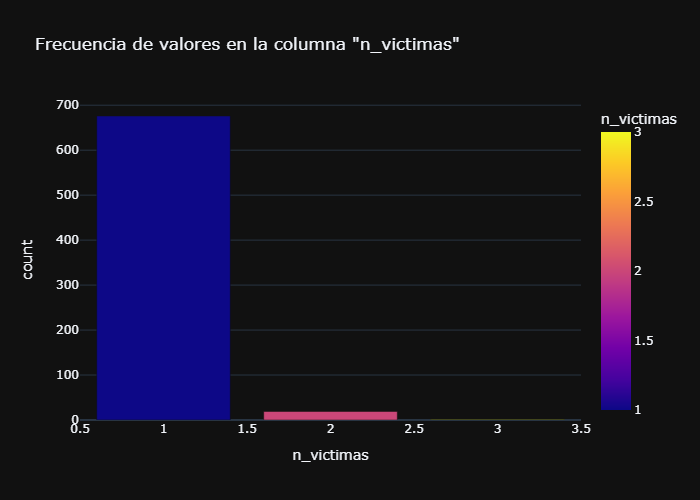

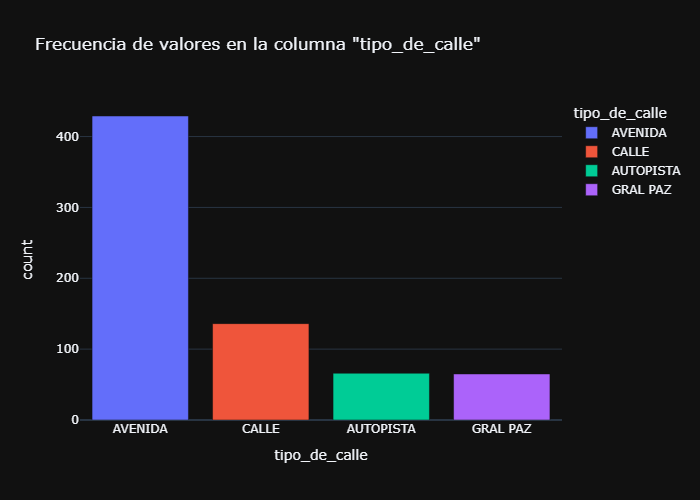

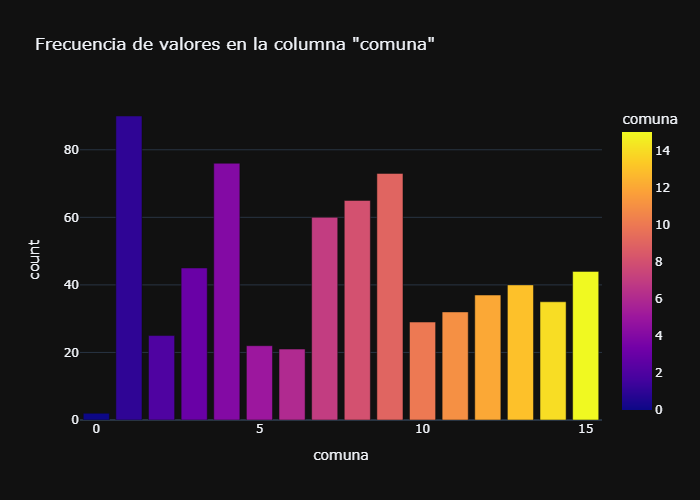

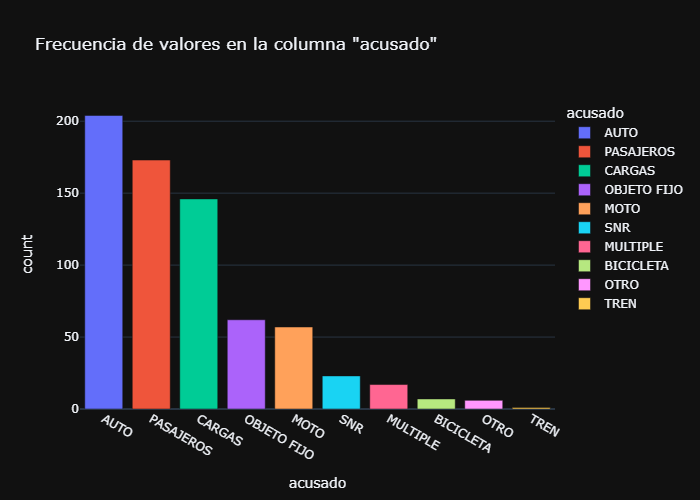

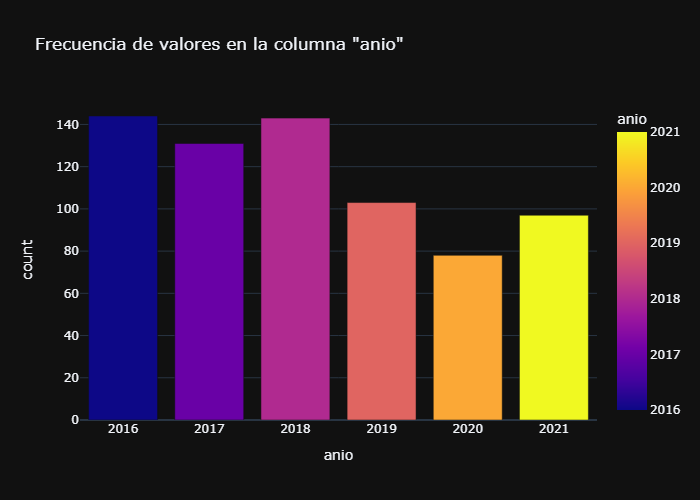

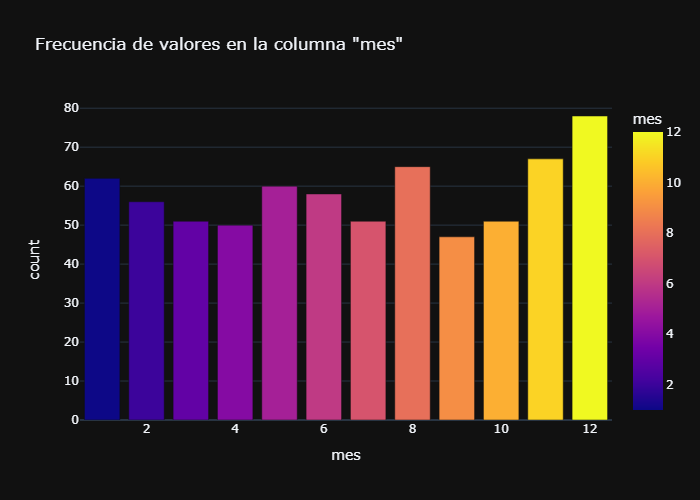

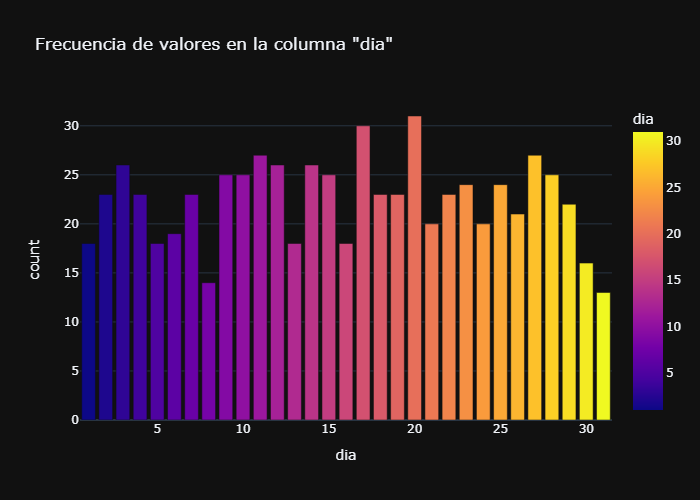

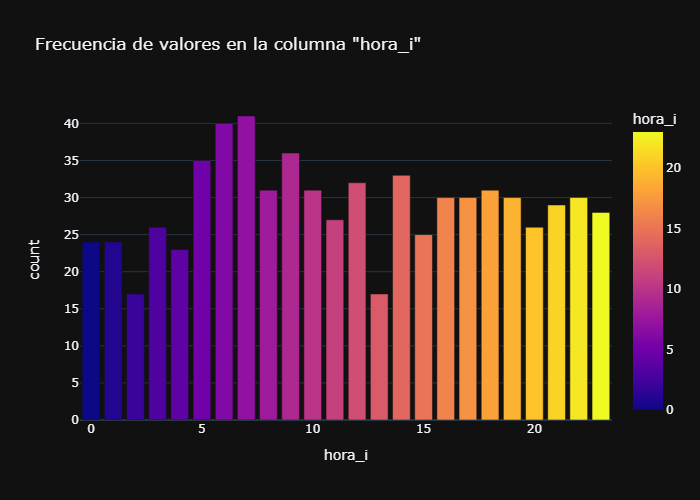

In [26]:
def barplot_visualization(df, column, filename):
    """
    Crea un gráfico de barras interactivo para visualizar la frecuencia de valores en una columna de un DataFrame.

    Parameters:
    - df (pd.DataFrame): El DataFrame que contiene los datos.
    - column (str): El nombre de la columna que se desea visualizar.

    Returns:
    None
    display image guardada
    """
    value_counts_df = df[column].value_counts().reset_index()
    value_counts_df.columns = ['values', 'count']

    fig = px.bar(value_counts_df, x='values', y='count', color='values',
                 labels={column: 'Frecuencia', 'values': column},
                 title=f'Frecuencia de valores en la columna "{column}"',
                 template='plotly_dark')
    image_path = f'images/{filename}.png'
    fig.write_image(image_path)

    display(Image(filename=image_path))

barplot_visualization(homicidios_lm, 'n_victimas','n_victimas_bar')
barplot_visualization(homicidios_lm, 'tipo_de_calle', 'tipo_de_calle_bar')
barplot_visualization(homicidios_lm, 'comuna', 'comuna_bar')
barplot_visualization(homicidios_lm, 'acusado', 'acusado_bar')
barplot_visualization(homicidios_lm, 'anio', 'anio_bar')
barplot_visualization(homicidios_lm, 'mes', 'mes_bar')
barplot_visualization(homicidios_lm, 'dia', 'dia_bar')
barplot_visualization(homicidios_lm, 'hora_i', 'hora_i_bar')


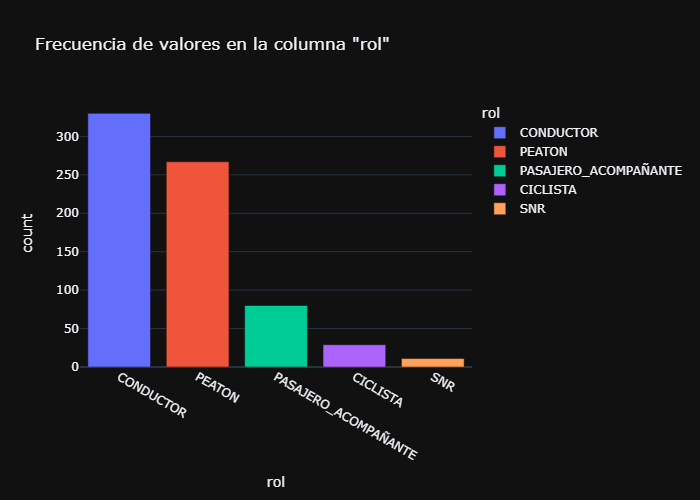

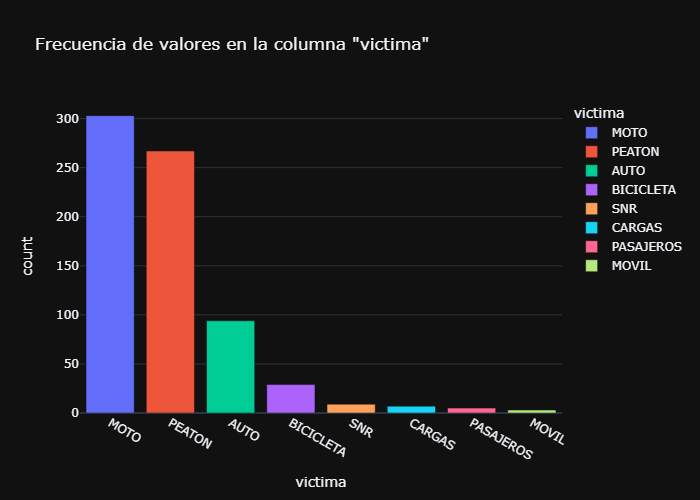

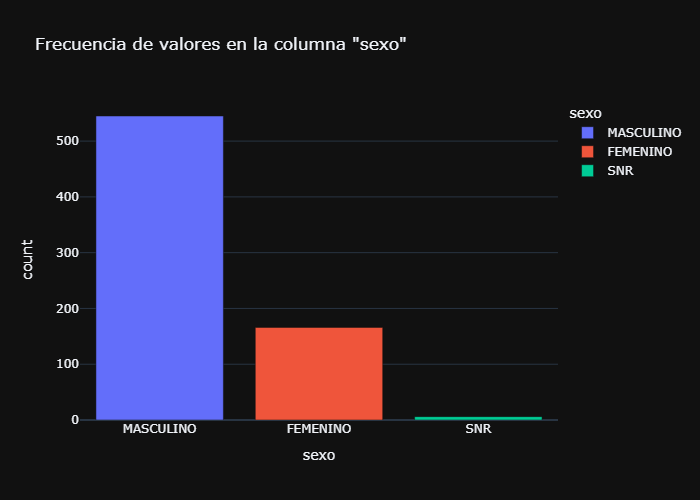

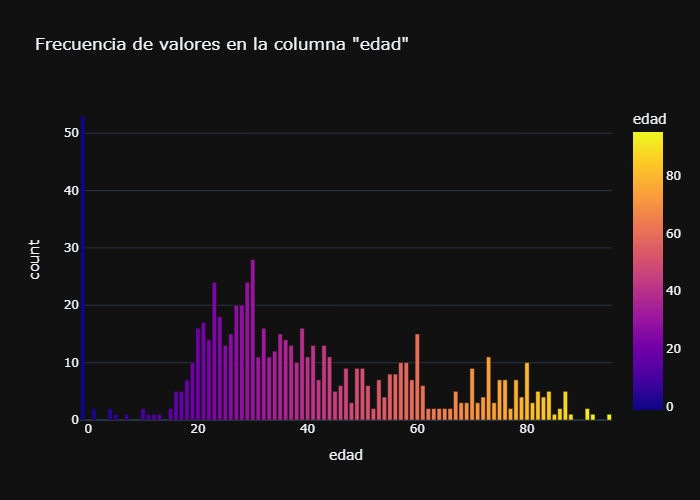

In [27]:
barplot_visualization(victima_h_lm, 'rol','rol_bar')
barplot_visualization(victima_h_lm, 'victima','victima_bar')
barplot_visualization(victima_h_lm, 'sexo', 'sexo_bar')
barplot_visualization(victima_h_lm, 'edad', 'edad_bar')

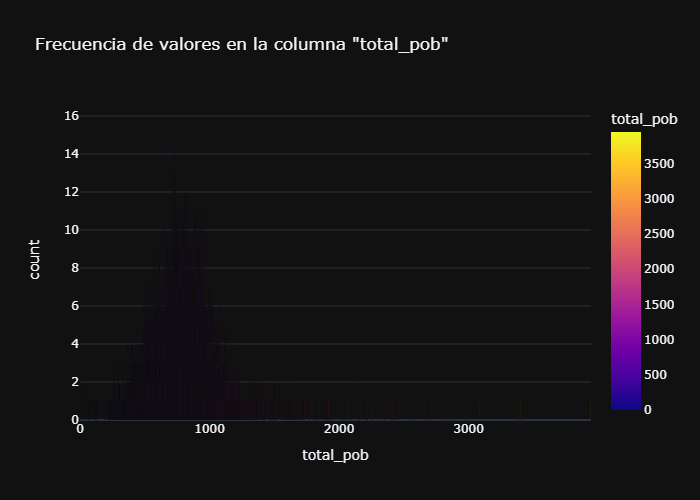

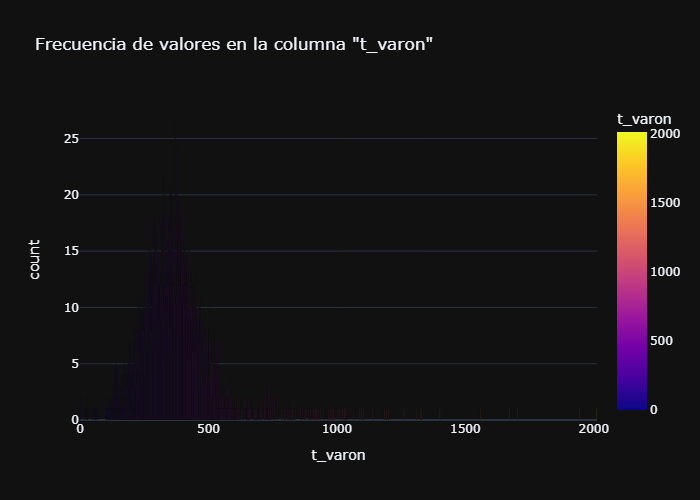

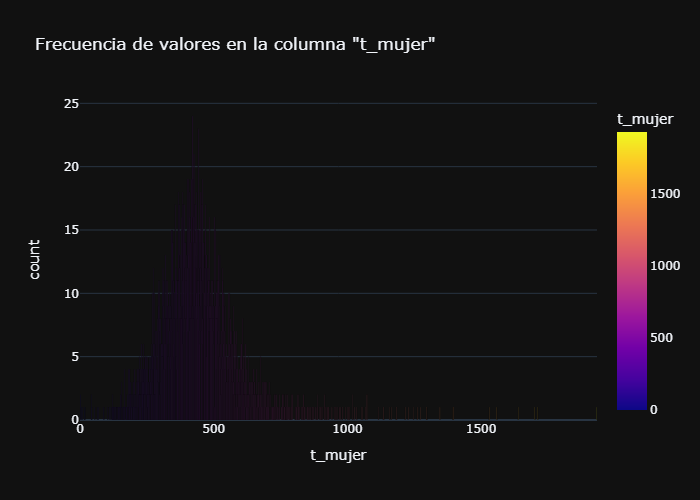

In [29]:
barplot_visualization(censo_r_l, 'total_pob','total_pob_bar')
barplot_visualization(censo_r_l, 't_varon','t_varon_bar')
barplot_visualization(censo_r_l, 't_mujer', 't_mujer_bar')


### Estrátegia para Modelado de  `homicidios`, `victima_h` ,`comunas_h`y `censo_r`.

In [30]:
victima_h_lm.columns 

Index(['id_hecho', 'rol', 'victima', 'sexo', 'edad', 'fecha_fallecimiento'], dtype='object')

In [31]:
homicidios_lm.columns

Index(['id', 'n_victimas', 'lugar_del_hecho', 'tipo_de_calle',
       'direccion_normalizada', 'comuna', 'longitud', 'latitud', 'acusado',
       'anio', 'mes', 'dia', 'fecha_hora', 'fecha_formato', 'hora_formato',
       'hora_i', 'coordenada_x', 'coordenada_y'],
      dtype='object')

In [32]:
homicidios_lm.comuna.value_counts()

comuna
1     90
4     76
9     73
8     65
7     60
3     45
15    44
13    40
12    37
14    35
11    32
10    29
2     25
5     22
6     21
0      2
Name: count, dtype: int64

In [33]:
comunas_h_l.columns

Index(['id', 'objeto', 'comunas', 'barrios', 'perimetro', 'area'], dtype='object')

In [34]:
comunas_h_l.head()

id          objeto  comunas                                  barrios  \
0   1  LIMITE COMUNAL        2                                 RECOLETA   
1   2  LIMITE COMUNAL        5                          ALMAGRO - BOEDO   
2   3  LIMITE COMUNAL        6                                CABALLITO   
3   4  LIMITE COMUNAL        7                FLORES - PARQUE CHACABUCO   
4   5  LIMITE COMUNAL        9  LINIERS - MATADEROS - PARQUE AVELLANEDA   

      perimetro          area  
0  21452.838648  6.317265e+06  
1  12323.432479  6.660603e+06  
2  10990.964471  6.851029e+06  
3  17972.257870  1.242290e+07  
4  21411.738344  1.650531e+07

In [35]:
comunas_h_l.comunas.value_counts()

comunas
2     1
5     1
6     1
7     1
9     1
10    1
11    1
12    1
14    1
3     1
15    1
8     1
4     1
1     1
13    1
Name: count, dtype: int64

In [36]:
censo_r_l.columns

Index(['wkt', 'id', 'co_frac_ra', 'comuna', 'fraccion', 'radio', 'total_pob',
       't_varon', 't_mujer', 't_vivienda', 'v_particul', 'v_colectiv',
       't_hogar', 'h_con_nbi', 'h_sin_nbi'],
      dtype='object')

In [37]:
censo_r_l.comuna.value_counts()

comuna
1     330
13    306
14    294
3     254
4     252
7     250
15    238
11    229
12    226
5     218
6     215
10    197
2     197
9     186
8     162
Name: count, dtype: int64

In [39]:
# Supongamos que tu DataFrame se llama homicidios_df
columnas_deseadas = ['id', 'n_victimas', 'tipo_de_calle', 'comuna', 'longitud', 'latitud', 'acusado',
                     'anio', 'mes', 'dia', 'hora_i']
# Puedes cambiar 'inner' por 'left', 'right', o 'outer' según tus necesidades específicas.
homicidios_lm = homicidios_lm[columnas_deseadas]

columnas_deseadas = ['comunas', 'barrios', 'perimetro', 'area']
comunas_h_l= comunas_h_l[columnas_deseadas]

columnas_deseadas = ['wkt', 'id', 'comuna',  'total_pob','t_varon', 't_mujer']
censo_r_l= censo_r_l[columnas_deseadas]
censo_r_lm= censo_r_l.groupby('comuna').agg({'total_pob': 'sum', 't_varon': 'sum', 't_mujer': 'sum'}).reset_index()

print(homicidios_lm.columns,  homicidios_lm.shape) # homicidios_lm 'id' se relaciona con  victima_h_lm 'id_hecho'
print(victima_h_lm.columns ,  victima_h_lm.shape) # victima_h_lm 'id_hecho'
print(comunas_h_l.columns ,  comunas_h_l.shape)# comunas_h_l 'comunas' se relaciona censo_r_l 'comuna'
print(censo_r_lm.columns ,  censo_r_lm.shape)# censo_r_l 'comuna'

Index(['id', 'n_victimas', 'tipo_de_calle', 'comuna', 'longitud', 'latitud',
       'acusado', 'anio', 'mes', 'dia', 'hora_i'],
      dtype='object') (696, 11)
Index(['id_hecho', 'rol', 'victima', 'sexo', 'edad', 'fecha_fallecimiento'], dtype='object') (717, 6)
Index(['comunas', 'barrios', 'perimetro', 'area'], dtype='object') (15, 4)
Index(['comuna', 'total_pob', 't_varon', 't_mujer'], dtype='object') (15, 4)


In [40]:


# Supongamos que tienes los DataFrames homicidios_lm, victima_h_lm, comunas_h_l, y censo_r_l
# Paso 1: Relacionar homicidios_lm y victima_h_lm
merged_df = pd.merge(homicidios_lm, victima_h_lm, left_on='id', right_on='id_hecho', how='inner')

# Paso 2: Relacionar merged_df y comunas_h_l
merged_df = pd.merge(merged_df, comunas_h_l, left_on='comuna', right_on='comunas', how='inner')

# Paso 3: Relacionar comunas_h_l y censo_r_l
merged_df = pd.merge(merged_df, censo_r_lm, left_on='comunas', right_on='comuna', how='inner')

In [41]:
merged_df.head(5)

id  n_victimas tipo_de_calle  comuna_x   longitud    latitud  \
0  2016-0001           1       AVENIDA         8 -58.475340 -34.687570   
1  2016-0002           1      GRAL PAZ         9 -58.508775 -34.669777   
2  2016-0003           1       AVENIDA         1 -58.390403 -34.631894   
3  2016-0004           1       AVENIDA         8 -58.465039 -34.680930   
4  2016-0005           1       AVENIDA         1 -58.387183 -34.622466   

     acusado  anio  mes  dia  hora_i   id_hecho        rol victima       sexo  \
0       AUTO  2016    1    1       4  2016-0001  CONDUCTOR    MOTO  MASCULINO   
1  PASAJEROS  2016    1    2       1  2016-0002  CONDUCTOR    AUTO  MASCULINO   
2       AUTO  2016    1    3       7  2016-0003  CONDUCTOR    MOTO  MASCULINO   
3        SNR  2016    1   10       0  2016-0004  CONDUCTOR    MOTO  MASCULINO   
4  PASAJEROS  2016    1   21       5  2016-0005  CONDUCTOR    MOTO  MASCULINO   

   edad fecha_fallecimiento  comunas  \
0    19          2016-01-01        8   
1    70          2016-01-02        9   
2    30          2016-01-03        1   
3    18          2016-01-17        8   
4    29          2016-02-01        1   

                                             barrios     perimetro  \
0     VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI  20935.012513   
1            LINIERS - MATADEROS - PARQUE AVELLANEDA  21411.738344   
2  CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...  36102.201573   
3     VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI  20935.012513   
4  CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...  36102.201573   

           area  comuna_y  total_pob  t_varon  t_mujer  
0  2.221690e+07         8     187237    89545    97692  
1  1.650531e+07         9     161797    76207    85590  
2  1.779457e+07         1     205991    98160   107831  
3  2.221690e+07         8     187237    89545    97692  
4  1.779457e+07         1     205991    98160   107831

In [42]:
merged_df.n_victimas.value_counts().sum()

715

In [43]:
merged_df.drop(['id_hecho','comunas', 'comuna_y', 'fecha_fallecimiento'], axis=1, inplace=True)
merged_df.shape

(715, 21)

## Análisis de Modelo  `Siniestros Fatales`.

In [44]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             715 non-null    object 
 1   n_victimas     715 non-null    int64  
 2   tipo_de_calle  715 non-null    object 
 3   comuna_x       715 non-null    int64  
 4   longitud       704 non-null    float64
 5   latitud        704 non-null    float64
 6   acusado        715 non-null    object 
 7   anio           715 non-null    int32  
 8   mes            715 non-null    int32  
 9   dia            715 non-null    int32  
 10  hora_i         715 non-null    int32  
 11  rol            715 non-null    object 
 12  victima        715 non-null    object 
 13  sexo           715 non-null    object 
 14  edad           715 non-null    int32  
 15  barrios        715 non-null    object 
 16  perimetro      715 non-null    float64
 17  area           715 non-null    float64
 18  total_pob 

### Estadística Descriptiva  en `Siniestros Fatales`.

In [45]:
merged_df.describe()

n_victimas    comuna_x    longitud     latitud         anio  \
count  715.000000  715.000000  704.000000  704.000000   715.000000   
mean     1.061538    7.451748  -58.441664  -34.619700  2018.180420   
std      0.257363    4.373508    0.046397    0.035292     1.671028   
min      1.000000    1.000000  -58.529942  -34.705250  2016.000000   
25%      1.000000    4.000000  -58.476556  -34.643918  2017.000000   
50%      1.000000    8.000000  -58.444513  -34.622866  2018.000000   
75%      1.000000   11.000000  -58.401841  -34.597013  2019.000000   
max      3.000000   15.000000  -58.356082  -34.534654  2021.000000   

              mes         dia      hora_i        edad     perimetro  \
count  715.000000  715.000000  715.000000  715.000000    715.000000   
mean     6.675524   15.934266   11.542657   39.088112  22882.611994   
std      3.570954    8.678986    6.697281   22.072691   8115.367993   
min      1.000000    1.000000    0.000000   -1.000000  10486.260809   
25%      4.000000    9.000000    6.000000   24.000000  17972.257870   
50%      7.000000   16.000000   11.000000   35.000000  20935.012513   
75%     10.000000   23.000000   17.000000   55.000000  26198.826953   
max     12.000000   31.000000   23.000000   95.000000  36102.201573   

               area      total_pob        t_varon        t_mujer  
count  7.150000e+02     715.000000     715.000000     715.000000  
mean   1.522497e+07  195830.172028   90925.372028  104904.800000  
std    4.855595e+06   22256.940783   10545.044500   12178.002061  
min    6.317265e+06  157827.000000   67979.000000   85590.000000  
25%    1.265656e+07  182574.000000   84485.000000   97692.000000  
50%    1.557093e+07  189832.000000   89545.000000  101936.000000  
75%    1.779457e+07  218245.000000  102481.000000  115079.000000  
max    2.221690e+07  231331.000000  103832.000000  127499.000000

In [46]:

merged_df.select_dtypes(include=['object']).columns
merged_df.tipo_de_calle.value_counts()

tipo_de_calle
AVENIDA      442
CALLE        137
GRAL PAZ      69
AUTOPISTA     67
Name: count, dtype: int64

In [47]:

# Supongamos que merged_df es tu DataFrame
object_columns = merged_df.select_dtypes(include=['object']).columns

# Diccionarios para almacenar los valores únicos y la moda de cada columna
unique_values_dict = {}
mode_values_dict = {}

# Iterar sobre las columnas de tipo objeto
for col in object_columns:
    unique_values_dict[col] = merged_df[col].unique()
    mode_values_dict[col] = merged_df[col].mode()

# Imprimir los resultados
for col, unique_values in unique_values_dict.items():
    print(f"Valores únicos en {col}: {unique_values[:5]}")

for col, mode_values in mode_values_dict.items():
    print(f"Moda en {col}: {mode_values}")

Valores únicos en id: ['2016-0001' '2016-0002' '2016-0003' '2016-0004' '2016-0005']
Valores únicos en tipo_de_calle: ['AVENIDA' 'GRAL PAZ' 'CALLE' 'AUTOPISTA']
Valores únicos en acusado: ['AUTO' 'PASAJEROS' 'SNR' 'OBJETO FIJO' 'CARGAS']
Valores únicos en rol: ['CONDUCTOR' 'PASAJERO_ACOMPAÑANTE' 'PEATON' 'SNR' 'CICLISTA']
Valores únicos en victima: ['MOTO' 'AUTO' 'PEATON' 'SNR' 'CARGAS']
Valores únicos en sexo: ['MASCULINO' 'FEMENINO' 'SNR']
Valores únicos en barrios: ['VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI'
 'LINIERS - MATADEROS - PARQUE AVELLANEDA'
 'CONSTITUCION - MONTSERRAT - PUERTO MADERO - RETIRO - SAN NICOLAS - SAN TELMO'
 'VILLA DEL PARQUE - VILLA  DEVOTO - VILLA GRAL. MITRE - VILLA SANTA RITA'
 'AGRONOMIA - CHACARITA -  PARQUE CHAS -  PATERNAL - VILLA CRESPO - VILLA ORTUZAR']
Moda en id: 0    2017-0035
Name: id, dtype: object
Moda en tipo_de_calle: 0    AVENIDA
Name: tipo_de_calle, dtype: object
Moda en acusado: 0    AUTO
Name: acusado, dtype: object
Moda en rol: 0    

## Preprocesamiento en el Modelo de `Siniestros Fatales`.

In [48]:
def limpiar_columnas_objeto(df):
    # Iterar sobre las columnas de tipo objeto
    for col in df.select_dtypes(include=['object']).columns:
        # Tratar los valores únicos
        df[col] = (
            df[col]
            .str.lower()
            .str.replace(' ', '')
            .str.replace('-', '_')
            .str.replace('___', '_')
            .str.replace('ã‘', 'n')
            .str.replace('.', '')
        )
        
    return df


# Supongamos que df es tu DataFrame
sinestrosdb = limpiar_columnas_objeto(merged_df.copy())

In [49]:
# Imprimir los valores únicos y la moda después del tratamiento

for col in sinestrosdb.select_dtypes(include=['object']).columns:
    unique_values = sinestrosdb[col].unique()
    mode_values = sinestrosdb[col].mode()
    
    print(f"Valores únicos en {col}: {unique_values[:5]}")
    print(f"Moda en {col}: {mode_values}")
    print("\n")

# columns_to_check = ['tipo_de_calle', 'acusado', 'rol', 'victima', 'sexo', 'barrios']

# for col in columns_to_check:
#     unique_values = sinestrosdb[col].unique()
#     mode_values = sinestrosdb[col].mode()
    
#     print(f"Columna: {col}")
#     print(f"Valores únicos: {unique_values[:5]}")
#     print(f"Moda: {mode_values}")
#     print("\n")

Valores únicos en id: ['2016_0001' '2016_0002' '2016_0003' '2016_0004' '2016_0005']
Moda en id: 0    2017_0035
Name: id, dtype: object


Valores únicos en tipo_de_calle: ['avenida' 'gralpaz' 'calle' 'autopista']
Moda en tipo_de_calle: 0    avenida
Name: tipo_de_calle, dtype: object


Valores únicos en acusado: ['auto' 'pasajeros' 'snr' 'objetofijo' 'cargas']
Moda en acusado: 0    auto
Name: acusado, dtype: object


Valores únicos en rol: ['conductor' 'pasajero_acompañante' 'peaton' 'snr' 'ciclista']
Moda en rol: 0    conductor
Name: rol, dtype: object


Valores únicos en victima: ['moto' 'auto' 'peaton' 'snr' 'cargas']
Moda en victima: 0    moto
Name: victima, dtype: object


Valores únicos en sexo: ['masculino' 'femenino' 'snr']
Moda en sexo: 0    masculino
Name: sexo, dtype: object


Valores únicos en barrios: ['villalugano_villariachuelo_villasoldati'
 'liniers_mataderos_parqueavellaneda'
 'constitucion_montserrat_puertomadero_retiro_sannicolas_santelmo'
 'villadelparque_villadevoto

## Normalización de Variables para el Modelo `Siniestros Fatales`.

In [50]:
# Seleccionar solo las columnas categóricas
categorical_columns = ['tipo_de_calle', 'acusado', 'rol', 'victima', 'sexo', 'barrios']
categorical_df = sinestrosdb[categorical_columns]

# Convertir las columnas categóricas a tipo str (si no lo están ya)
categorical_df = categorical_df.astype(str)

# Aplicar one-hot encoding
onehot_df = pd.get_dummies(categorical_df, drop_first=True)

# Concatenar el DataFrame original con las nuevas columnas codificadas
result_df = pd.concat([sinestrosdb, onehot_df], axis=1)

# Eliminar las columnas originales categóricas (opcional)
result_df = result_df.drop(columns=categorical_columns)

# Convertir columnas booleanas a tipo entero (1 y 0)
result_df[onehot_df.columns] = result_df[onehot_df.columns].astype(int)

# Imprimir las dimensiones del DataFrame resultante
print("Dimensiones del DataFrame resultante:", result_df.shape)



Dimensiones del DataFrame resultante: (715, 54)


In [51]:
result_df.head()

id  n_victimas  comuna_x   longitud    latitud  anio  mes  dia  \
0  2016_0001           1         8 -58.475340 -34.687570  2016    1    1   
1  2016_0002           1         9 -58.508775 -34.669777  2016    1    2   
2  2016_0003           1         1 -58.390403 -34.631894  2016    1    3   
3  2016_0004           1         8 -58.465039 -34.680930  2016    1   10   
4  2016_0005           1         1 -58.387183 -34.622466  2016    1   21   

   hora_i  edad     perimetro          area  total_pob  t_varon  t_mujer  \
0       4    19  20935.012513  2.221690e+07     187237    89545    97692   
1       1    70  21411.738344  1.650531e+07     161797    76207    85590   
2       7    30  36102.201573  1.779457e+07     205991    98160   107831   
3       0    18  20935.012513  2.221690e+07     187237    89545    97692   
4       5    29  36102.201573  1.779457e+07     205991    98160   107831   

   tipo_de_calle_avenida  tipo_de_calle_calle  tipo_de_calle_gralpaz  \
0                      1                    0                      0   
1                      0                    0                      1   
2                      1                    0                      0   
3                      1                    0                      0   
4                      1                    0                      0   

   acusado_bicicleta  acusado_cargas  acusado_moto  acusado_multiple  \
0                  0               0             0                 0   
1                  0               0             0                 0   
2                  0               0             0                 0   
3                  0               0             0                 0   
4                  0               0             0                 0   

   acusado_objetofijo  acusado_otro  acusado_pasajeros  acusado_snr  \
0                   0             0                  0            0   
1                   0             0                  1            0   
2                   0             0                  0            0   
3                   0             0                  0            1   
4                   0             0                  1            0   

   acusado_tren  rol_conductor  rol_pasajero_acompañante  rol_peaton  rol_snr  \
0             0              1                         0           0        0   
1             0              1                         0           0        0   
2             0              1                         0           0        0   
3             0              1                         0           0        0   
4             0              1                         0           0        0   

   victima_bicicleta  victima_cargas  victima_moto  victima_movil  \
0                  0               0             1              0   
1                  0               0             0              0   
2                  0               0             1              0   
3                  0               0             1              0   
4                  0               0             1              0   

   victima_pasajeros  victima_peaton  victima_snr  sexo_masculino  sexo_snr  \
0                  0               0            0               1         0   
1                  0               0            0               1         0   
2                  0               0            0               1         0   
3                  0               0            0               1         0   
4                  0               0            0               1         0   

   barrios_almagro_boedo  barrios_balvanera_sancristobal  \
0                      0                               0   
1                      0                               0   
2                      0                               0   
3                      0                               0   
4                      0                               0   

   barrios_barracas_boca_nuevapompeya_parquepatricios  \
0       

In [52]:
result_df['id'] = pd.Categorical(result_df['id']).codes

In [53]:
result_df.head(15)

id  n_victimas  comuna_x   longitud    latitud  anio  mes  dia  hora_i  \
0    0           1         8 -58.475340 -34.687570  2016    1    1       4   
1    1           1         9 -58.508775 -34.669777  2016    1    2       1   
2    2           1         1 -58.390403 -34.631894  2016    1    3       7   
3    3           1         8 -58.465039 -34.680930  2016    1   10       0   
4    4           1         1 -58.387183 -34.622466  2016    1   21       5   
5    5           1         8 -58.444513 -34.684759  2016    1   24      18   
6    6           1        11 -58.500959 -34.608254  2016    1   24      19   
7    7           1         9 -58.508775 -34.669777  2016    1   29      15   
8    8           1         1 -58.380486 -34.613039  2016    2    8       1   
9    9           1         1 -58.391149 -34.624774  2016    2   10      11   
10  10           1        15 -58.437600 -34.599128  2016    2   14       5   
11  11           1         4 -58.368827 -34.642920  2016    2   14      22   
12  12           1         8 -58.449897 -34.659704  2016    2   15      16   
13  13           1         9 -58.509909 -34.654687  2016    2   17       9   
14  14           1         1 -58.379522 -34.606533  2016    2   17      16   

    edad     perimetro          area  total_pob  t_varon  t_mujer  \
0     19  20935.012513  2.221690e+07     187237    89545    97692   
1     70  21411.738344  1.650531e+07     161797    76207    85590   
2     30  36102.201573  1.779457e+07     205991    98160   107831   
3     18  20935.012513  2.221690e+07     187237    89545    97692   
4     29  36102.201573  1.779457e+07     205991    98160   107831   
5     30  20935.012513  2.221690e+07     187237    89545    97692   
6     29  19987.696155  1.412004e+07     189832    88469   101363   
7     18  21411.738344  1.650531e+07     161797    76207    85590   
8     22  36102.201573  1.779457e+07     205991    98160   107831   
9     16  36102.201573  1.779457e+07     205991    98160   107831   
10    16  17832.585580  1.432290e+07     182574    84485    98089   
11    19  35423.282799  2.168464e+07     218245   103166   115079   
12    59  20935.012513  2.221690e+07     187237    89545    97692   
13    65  21411.738344  1.650531e+07     161797    76207    85590   
14    59  36102.201573  1.779457e+07     205991    98160   107831   

    tipo_de_calle_avenida  tipo_de_calle_calle  tipo_de_calle_gralpaz  \
0                       1                    0                      0   
1                       0                    0                      1   
2                       1                    0                      0   
3                       1                    0                      0   
4                       1                    0                      0   
5                       1                    0                      0   
6                       0                    1                      0   
7                       0                    0                      1   
8                       1                    0                      0   
9                       1                    0                      0   
10                      1                    0                      0   
11                      1                    0                      0   
12                      1                    0                      0   
13                      0                    1                      0   
14                      0                    1                      0   

    acusado_bicicleta  acusado_cargas  acusado_moto  acusado_multiple  \
0                   0               0             0                 0   
1                   0               0             0                 0   
2                   0               0             0                 0   
3                   0               0             0                 0   
4                   0               0             0                 0   
5                   0               0      

## Correlación en el Modelo de `Siniestros Fatales`.

<Axes: >

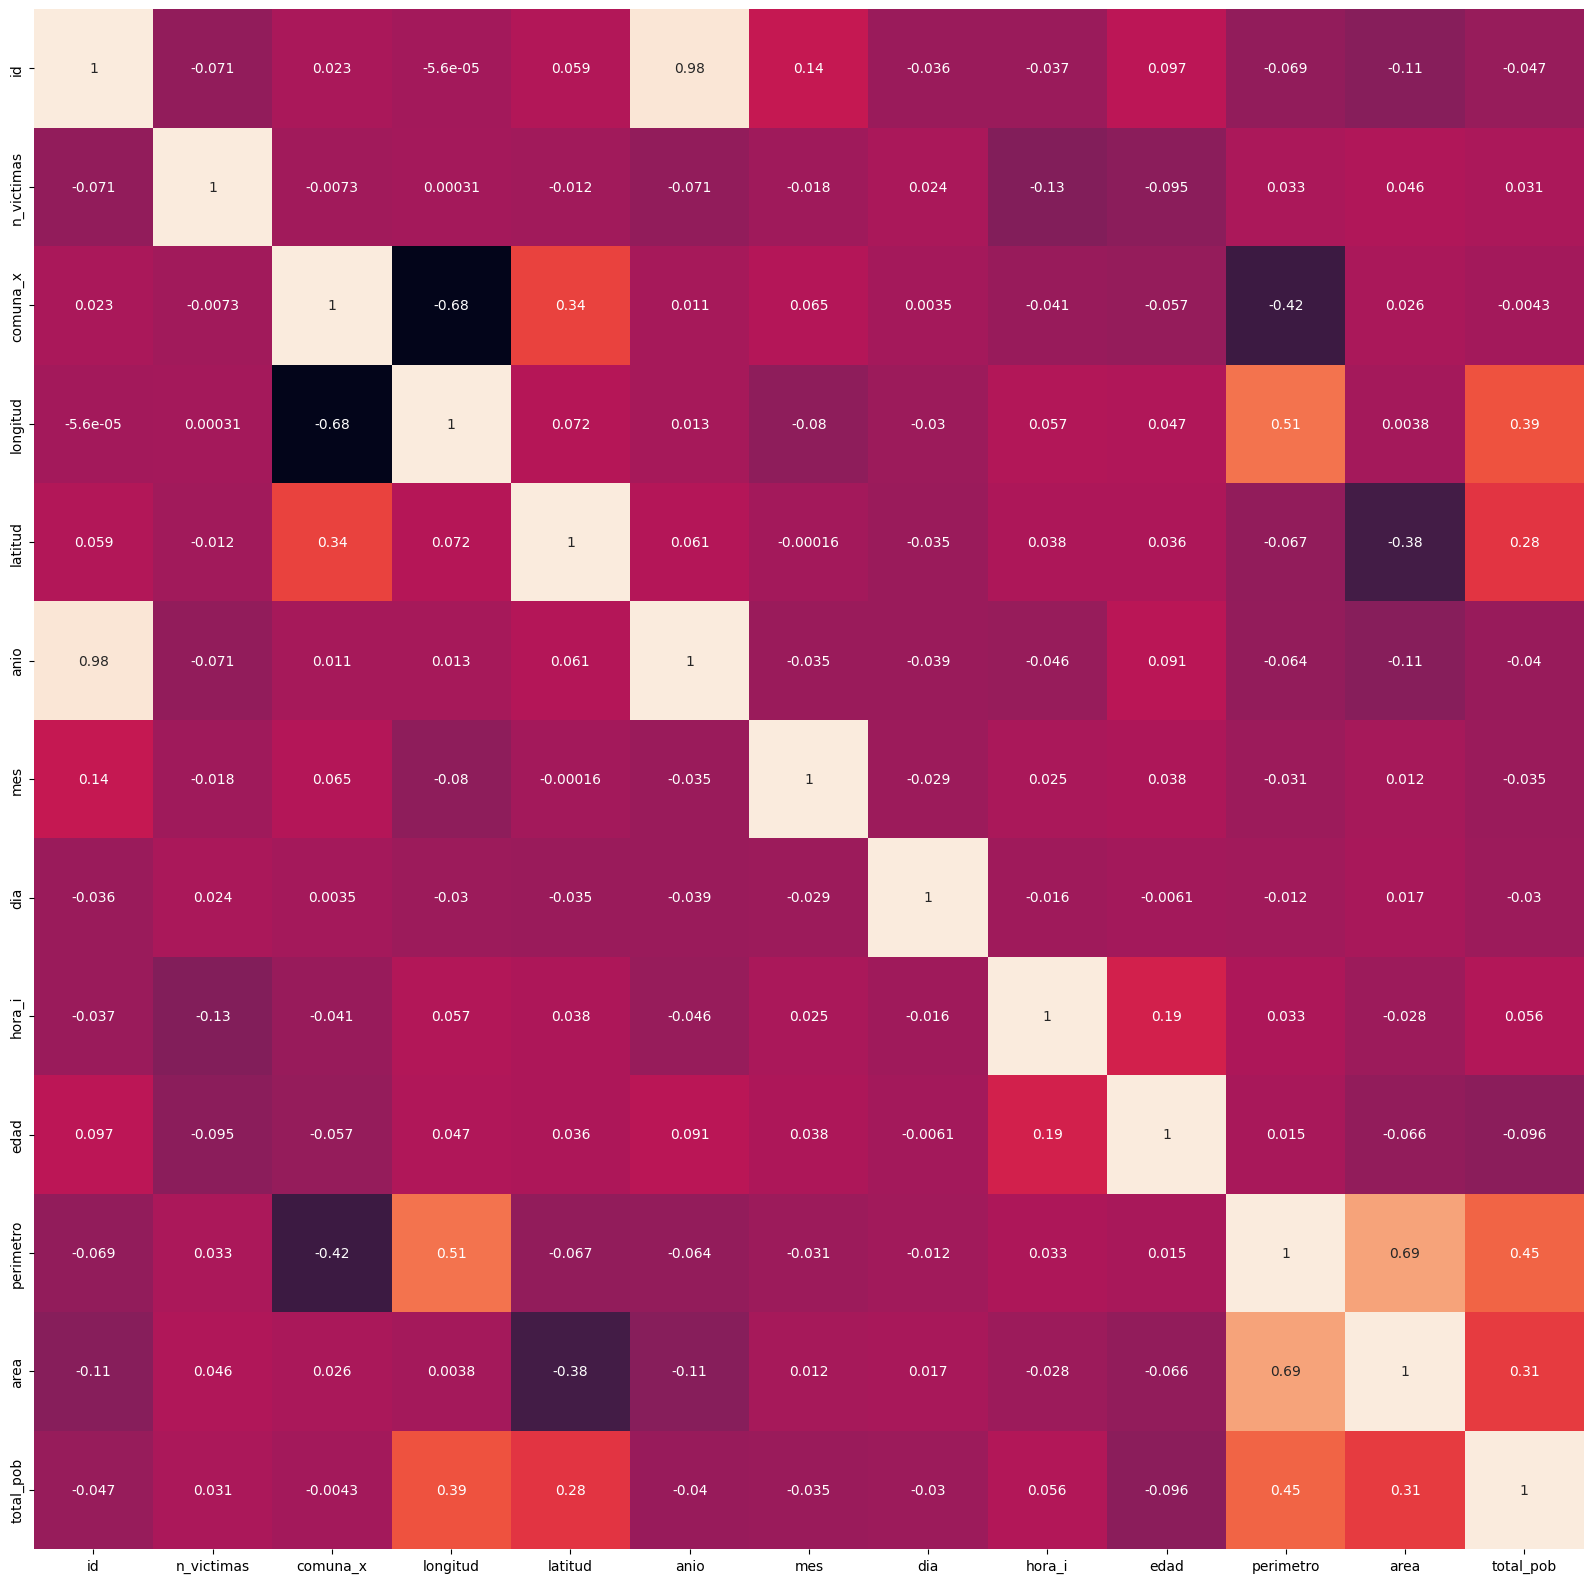

In [54]:
plt.figure(figsize = (20, 20))
corr_matrix = result_df.iloc[:, :13].corr()
sns.heatmap(corr_matrix, annot = True, cbar = False)


1. **Correlación Positiva Muy Fuerte:**
   - La variable "anio" tiene una correlación positiva muy fuerte con la variable "id" (0.98). Esto indica una fuerte relación lineal positiva entre el año y el identificador.

2. **Correlación Negativa Moderada:**
   - La variable "comuna_x" y "longitud" tienen una correlación negativa moderada de -0.68. Esto podría indicar que hay alguna relación inversa entre la comuna y la longitud.

3. **Correlación Baja o No Significativa:**
   - En general, la mayoría de las variables tienen correlaciones bajas o no significativas entre sí.

4. **Impacto de Variables en "total_pob":**
   - La variable "area" tiene una correlación positiva considerable con "total_pob" (0.31), lo que sugiere que a medida que aumenta el área, también lo hace la población total.
   - La variable "perimetro" también muestra una correlación positiva decente con "total_pob" (0.45).

5. **Relación No Lineal:**
   - La correlación no captura relaciones no lineales. Por lo tanto, es importante tener en cuenta que algunas relaciones pueden no ser evidentes en este análisis.

Es esencial recordar que la correlación no implica causalidad.

In [55]:
result_df.drop(['perimetro'], axis=1, inplace=True)

In [56]:
result_df.head(5)

id  n_victimas  comuna_x   longitud    latitud  anio  mes  dia  hora_i  \
0   0           1         8 -58.475340 -34.687570  2016    1    1       4   
1   1           1         9 -58.508775 -34.669777  2016    1    2       1   
2   2           1         1 -58.390403 -34.631894  2016    1    3       7   
3   3           1         8 -58.465039 -34.680930  2016    1   10       0   
4   4           1         1 -58.387183 -34.622466  2016    1   21       5   

   edad          area  total_pob  t_varon  t_mujer  tipo_de_calle_avenida  \
0    19  2.221690e+07     187237    89545    97692                      1   
1    70  1.650531e+07     161797    76207    85590                      0   
2    30  1.779457e+07     205991    98160   107831                      1   
3    18  2.221690e+07     187237    89545    97692                      1   
4    29  1.779457e+07     205991    98160   107831                      1   

   tipo_de_calle_calle  tipo_de_calle_gralpaz  acusado_bicicleta  \
0                    0                      0                  0   
1                    0                      1                  0   
2                    0                      0                  0   
3                    0                      0                  0   
4                    0                      0                  0   

   acusado_cargas  acusado_moto  acusado_multiple  acusado_objetofijo  \
0               0             0                 0                   0   
1               0             0                 0                   0   
2               0             0                 0                   0   
3               0             0                 0                   0   
4               0             0                 0                   0   

   acusado_otro  acusado_pasajeros  acusado_snr  acusado_tren  rol_conductor  \
0             0                  0            0             0              1   
1             0                  1            0             0              1   
2             0                  0            0             0              1   
3             0                  0            1             0              1   
4             0                  1            0             0              1   

   rol_pasajero_acompañante  rol_peaton  rol_snr  victima_bicicleta  \
0                         0           0        0                  0   
1                         0           0        0                  0   
2                         0           0        0                  0   
3                         0           0        0                  0   
4                         0           0        0                  0   

   victima_cargas  victima_moto  victima_movil  victima_pasajeros  \
0               0             1              0                  0   
1               0             0              0                  0   
2               0             1              0                  0   
3               0             1              0                  0   
4               0             1              0                  0   

   victima_peaton  victima_snr  sexo_masculino  sexo_snr  \
0               0            0               1         0   
1               0            0               1         0   
2               0            0               1         0   
3               0            0               1         0   
4               0            0               1         0   

   barrios_almagro_boedo  barrios_balvanera_sancristobal  \
0                      0                               0   
1                      0                               0   
2                      0                               0   
3                      0                               0   
4                      0                               0   

   barrios_barracas_boca_nuevapompeya_parquepatricios  \
0                                                  0    
1                                                  0    
2            

In [57]:
result_df.total_pob.value_counts().index
# 2,753,330 Válido Población estimada 2010-  Cabe aclarar de poblacion es una etiqueta

Index([205991, 218245, 161797, 187237, 220591, 187537, 182574, 231331, 200116,
       225970, 189832, 166022, 157827, 176076, 179005],
      dtype='int64', name='total_pob')

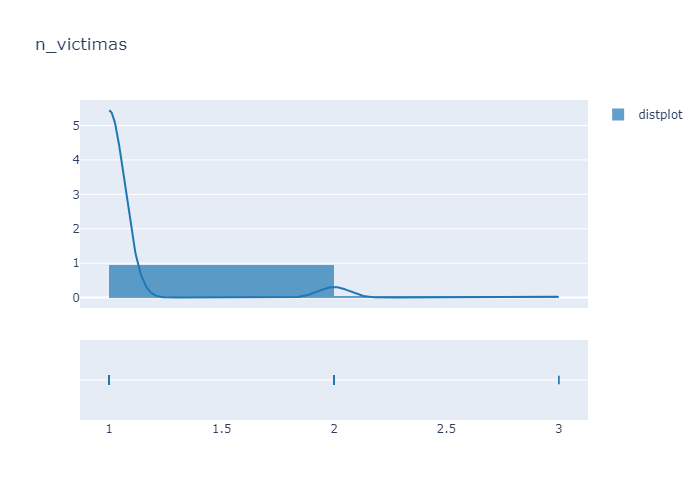

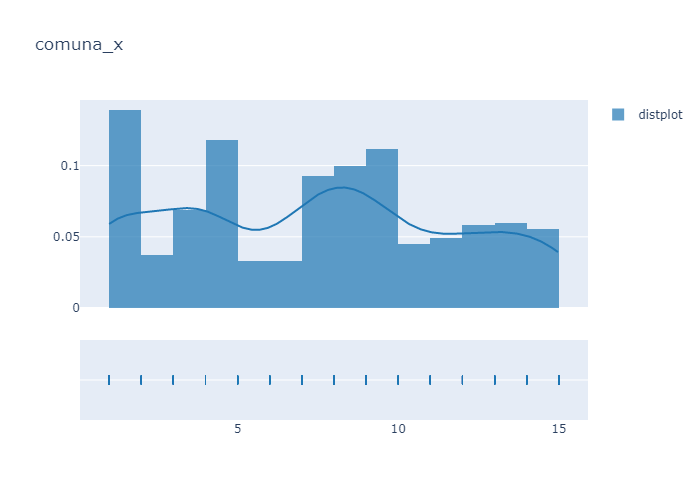

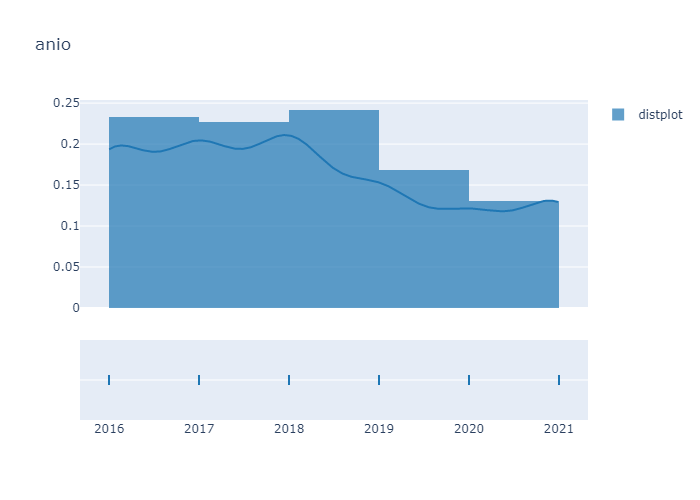

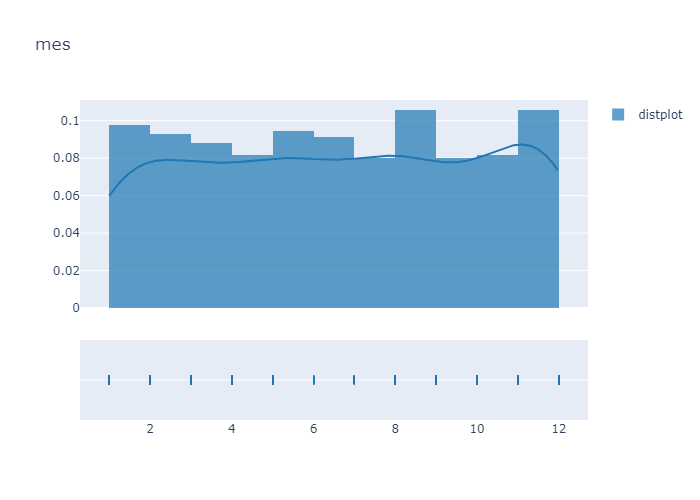

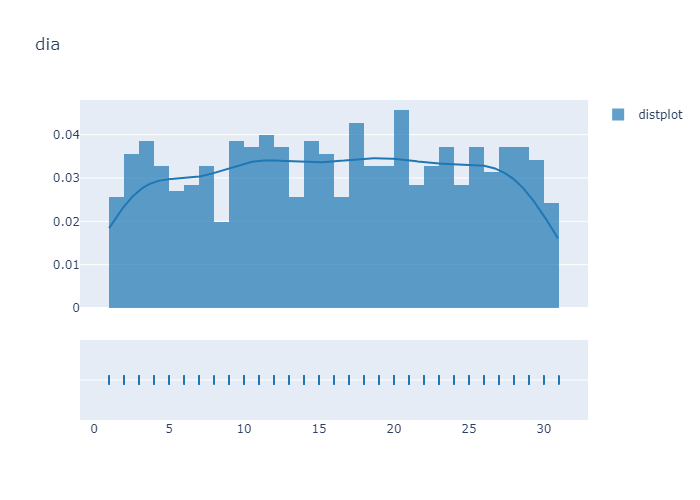

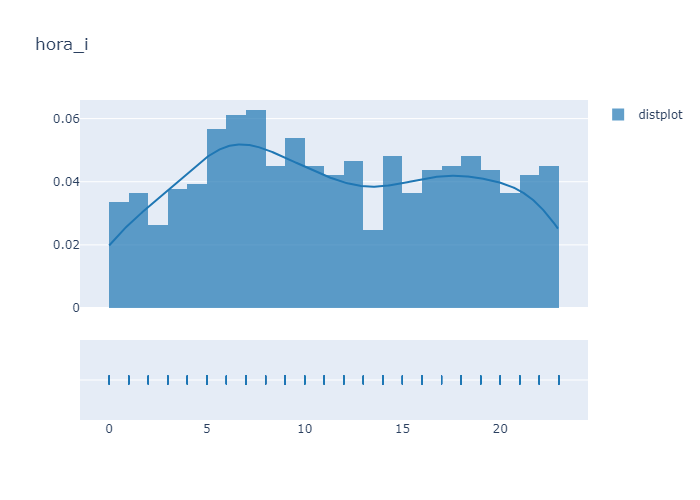

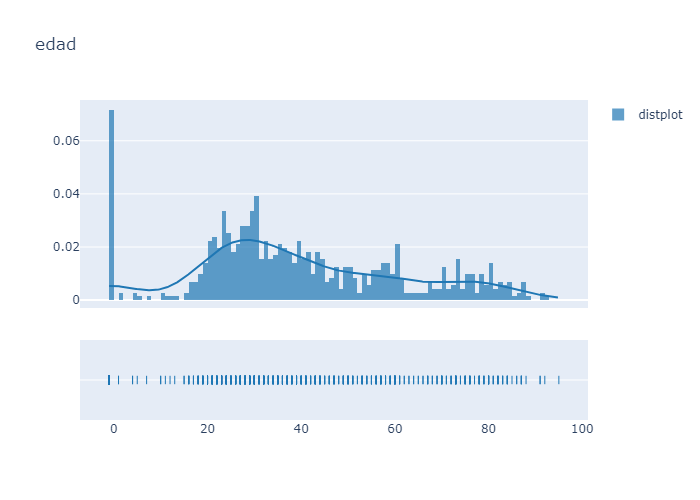

<Figure size 1000x1000 with 0 Axes>

In [59]:

plt.figure(figsize=(10, 10))

selected_columns = [1, 2, 5, 6, 7, 8, 9]

for col_index in selected_columns:
    col_name = result_df.columns[col_index]
    fig = ff.create_distplot([result_df[col_name].dropna().apply(lambda x: float(x))], ['distplot'])
    fig.update_layout(title_text=col_name)
    
    # Guardar la imagen en formato PNG
    image_path = f'images/{col_name}_distplot.png'
    fig.write_image(image_path)
    
    # Mostrar la imagen en el notebook
    display(Image(filename=image_path))

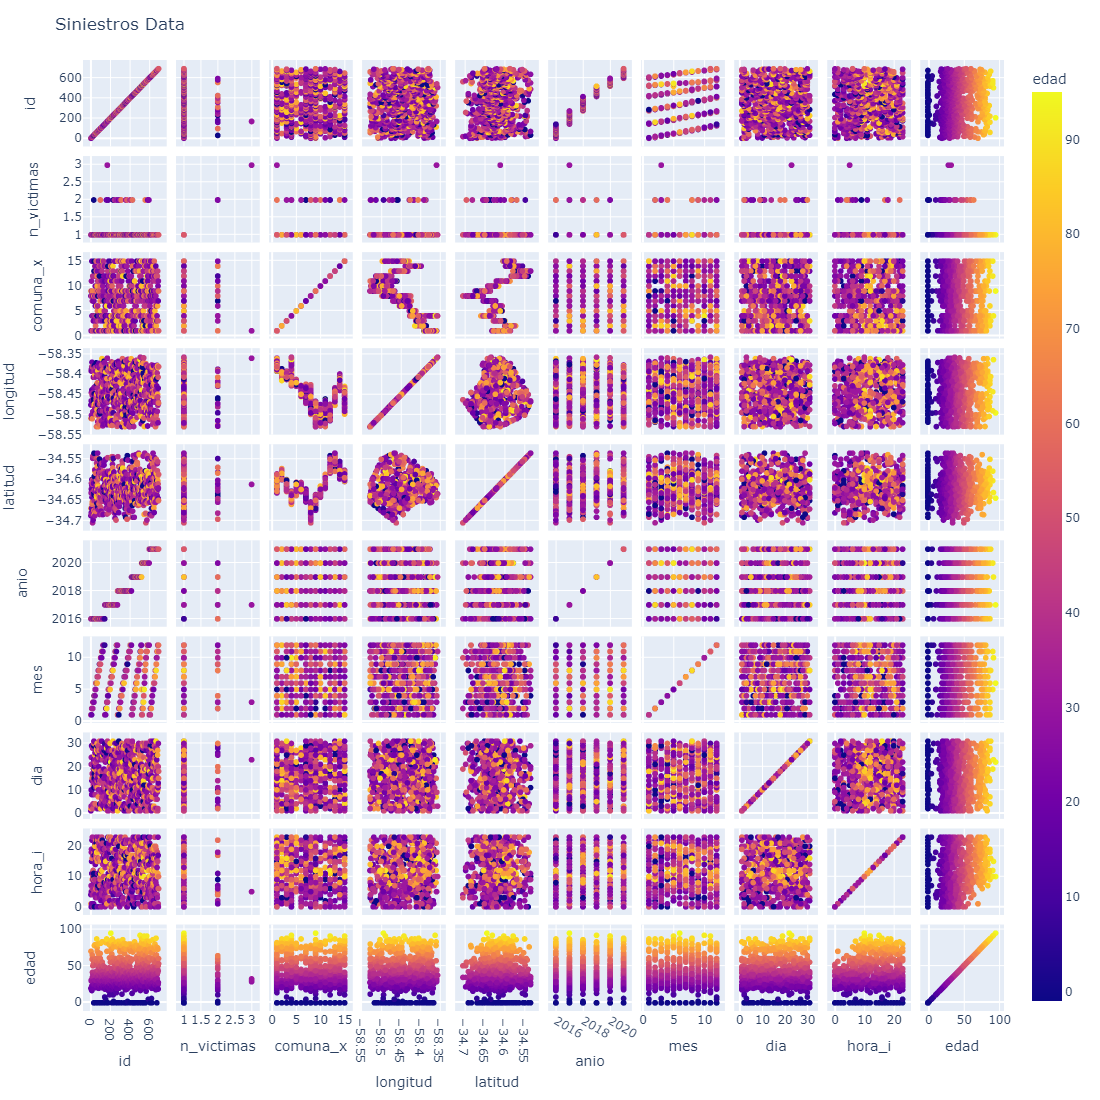

<Figure size 1500x1500 with 0 Axes>

In [60]:
# Visualizar la relación entre variables usando parcelas
plt.figure(figsize=(15, 15))

fig = px.scatter_matrix(result_df,
                        dimensions=result_df.columns[:10], color='edad')

fig.update_layout(
    title='Siniestros Data',
    width=1100,
    height=1100,
)

# Guardar la imagen en formato PNG
scatter_matrix_image_path = 'images/scatter_matrix.png'
fig.write_image(scatter_matrix_image_path)

# Mostrar la imagen en el notebook
display(Image(filename=scatter_matrix_image_path))

In [61]:
# Tratarmiento los valores faltantes en longitud y latitud con la moda
result_df['longitud'] = result_df['longitud'].fillna(result_df['longitud'].mode()[0])
result_df['latitud'] = result_df['latitud'].fillna(result_df['latitud'].mode()[0])

In [62]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 53 columns):
 #   Column                                                                     Non-Null Count  Dtype  
---  ------                                                                     --------------  -----  
 0   id                                                                         715 non-null    int16  
 1   n_victimas                                                                 715 non-null    int64  
 2   comuna_x                                                                   715 non-null    int64  
 3   longitud                                                                   715 non-null    float64
 4   latitud                                                                    715 non-null    float64
 5   anio                                                                       715 non-null    int32  
 6   mes                                                       

## Clisters Método el codo de `Siniestros Fatales`.

In [64]:
# Escalamos los datos
scaler = StandardScaler()
result_df_scaled = scaler.fit_transform(result_df)

In [65]:
result_df_scaled.shape

(715, 53)

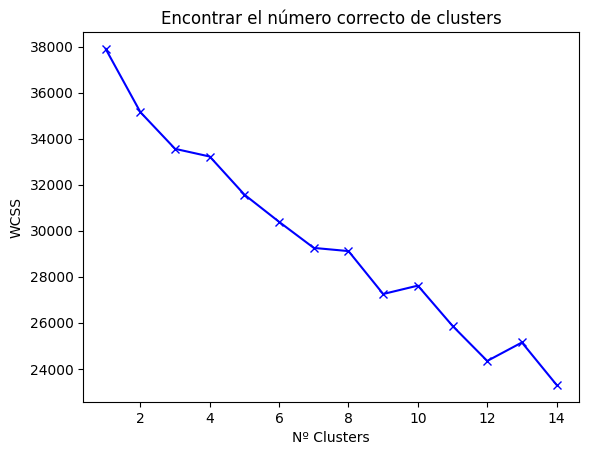

In [66]:
scores = []

range_values = range(1, 15)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(result_df_scaled)
  scores.append(kmeans.inertia_) # la inercia es la suma de los cuadrados de las distancias de las observaciones al centro del cluster más cercano

plt.plot(range_values, scores, 'bx-')
plt.title('Encontrar el número correcto de clusters')
plt.xlabel('Nº Clusters')
plt.ylabel('WCSS')
plt.show()

In [67]:
# Agrupar los datos usando k-means
kmeans = KMeans(5)
kmeans.fit(result_df_scaled)
labels = kmeans.labels_

In [68]:
labels

array([4, 3, 1, 4, 1, 4, 1, 3, 1, 2, 2, 1, 4, 3, 2, 1, 1, 4, 1, 1, 2, 2,
       4, 2, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 2, 2, 4, 4, 1, 4, 2, 4, 2, 1,
       2, 2, 3, 0, 4, 1, 1, 3, 4, 4, 2, 2, 1, 1, 3, 1, 2, 0, 2, 4, 3, 1,
       2, 2, 2, 1, 0, 1, 4, 2, 1, 1, 1, 3, 3, 3, 2, 2, 1, 3, 3, 1, 1, 3,
       1, 1, 4, 1, 1, 1, 3, 1, 2, 3, 3, 3, 4, 2, 1, 2, 1, 1, 4, 2, 4, 1,
       1, 1, 1, 1, 4, 2, 1, 2, 1, 1, 1, 1, 2, 4, 3, 1, 1, 4, 3, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1,
       2, 1, 1, 3, 1, 2, 1, 1, 1, 2, 0, 3, 3, 1, 4, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 4, 4, 3, 3, 1, 4, 1, 1, 1, 2, 2, 4, 2, 3, 2, 1,
       1, 2, 0, 4, 3, 2, 1, 1, 3, 2, 2, 1, 1, 3, 2, 3, 2, 2, 3, 2, 2, 3,
       2, 1, 2, 2, 3, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1,
       2, 1, 1, 1, 1, 3, 4, 1, 4, 4, 4, 1, 0, 3, 1, 4, 4, 1, 2, 2, 1, 4,
       1, 0, 1, 4, 1, 3, 2, 2, 3, 2, 1, 0, 0, 2, 1, 3, 1, 1, 2, 3, 2, 2,
       2, 1, 2, 0, 3, 1, 1, 3, 2, 4, 1, 2, 1, 1, 1,

In [69]:
kmeans.cluster_centers_.shape

(5, 53)

In [70]:
# Echemos un vistazo a los centros de los clústeres
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [result_df.columns])
cluster_centers

id n_victimas  comuna_x  longitud   latitud      anio       mes  \
0  0.078416   0.114201 -0.332174  0.031581  0.003197  0.109720 -0.010974   
1  0.008182   0.103805 -0.000176  0.202432  0.361231  0.015248 -0.014388   
2  0.056668  -0.147140 -0.208552  0.484926  0.363292  0.056569 -0.052508   
3  0.052634  -0.017091  0.419629 -1.259960 -0.711701  0.006022  0.195015   
4 -0.305807  -0.020221  0.102887 -0.460036 -1.584971 -0.276736 -0.066949   

        dia    hora_i      edad      area total_pob   t_varon   t_mujer  \
0  0.211977 -0.318795 -0.022541 -1.725804 -0.888172 -1.144027 -0.632632   
1  0.018507 -0.150421 -0.347278 -0.103474  0.414060  0.377963  0.429469   
2 -0.090236  0.325393  0.521136 -0.164519  0.327362  0.275159  0.360036   
3 -0.001206 -0.059738  0.147127  0.037239 -1.475900 -1.375997 -1.505917   
4  0.124505 -0.131591 -0.262605  1.414566 -0.299529 -0.057281 -0.497829   

  tipo_de_calle_avenida tipo_de_calle_calle tipo_de_calle_gralpaz  \
0              0.318105            0.090618             -0.326820   
1             -0.021280           -0.013553              0.016268   
2              0.171335            0.151376             -0.278669   
3             -0.311867            0.021322              0.253742   
4             -0.054818           -0.451064              0.484059   

  acusado_bicicleta acusado_cargas acusado_moto acusado_multiple  \
0         -0.099433      -0.068701    -0.130630         0.142292   
1         -0.033052       0.086718    -0.033783         0.015540   
2          0.141240      -0.212614     0.154217        -0.000522   
3         -0.099433       0.186473    -0.122702        -0.031038   
4         -0.099433       0.003629    -0.090767        -0.063614   

  acusado_objetofijo acusado_otro acusado_pasajeros acusado_snr acusado_tren  \
0          -0.165575    -0.091993          0.265226   -0.173952    -0.037424   
1           0.183078     0.015482         -0.197852   -0.019111    -0.037424   
2          -0.321551    -0.091993          0.366859   -0.145883    -0.037424   
3          -0.060105    -0.091993         -0.069156    0.164485     0.217416   
4           0.306748     0.371209         -0.217438    0.326554    -0.037424   

  rol_conductor rol_pasajero_acompañante rol_peaton   rol_snr  \
0      0.168331                -0.210747  -0.017362 -0.119098   
1      0.568805                 0.225609  -0.769693 -0.035613   
2     -0.925820                -0.354943   1.269803 -0.119098   
3      0.048495                 0.037818  -0.139168  0.205303   
4      0.176036                 0.091860  -0.245180  0.240713   

  victima_bicicleta victima_cargas victima_moto victima_movil  \
0          0.024815      -0.099433     0.154250     -0.064911   
1          0.109152       0.066521     0.597338      0.086761   
2         -0.133532      -0.099433    -0.857576     -0.064911   
3          0.035787       0.094022    -0.144479     -0.064911   
4         -0.134208      -0.099433     0.139999     -0.064911   

  victima_pasajeros victima_peaton victima_snr sexo_masculino  sexo_snr  \
0         -0.083918      -0.017362   -0.106374      -0.082133 -0.075006   
1          0.072948      -0.769693   -0.013166       0.266798 -0.031191   
2         -0.083918       1.269803   -0.106374      -0.376644 -0.075006   
3          0.030370      -0.139168    0.255804      -0.023154 -0.075006   
4         -0.083918      -0.245180    0.027530       0.029151  0.491500   

  barrios_almagro_boedo barrios_balvanera_sancristobal  \
0             -0.178174                      -0.262220   
1              0.011063                       0.124050   
2              0.151152                       0.066163   
3             -0.178174                      -0.262220   
4             -0.178174                      -0.262220   

  barrios_barracas_boca_nuevapompeya_parquepatricios  \
0                                          -0.352440   
1                                           0.127073   
2                                           0.

In [71]:
# Para entender lo que significan estos números, realicemos una transformación inversa
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [result_df.columns])
cluster_centers

# Clúster 0 (más alto): este grupo representa a los clientes que compran artículos en una gran cantidad centrada en ~ 47, compran artículos en todos los rangos de precios inclinándose hacia artículos de alto precio de ~ 99. También corresponden a las ventas totales más altas alrededor de ~ 8296 y están activas durante todo el año. Son los mayores compradores de productos con un MSRP alto ~ 158.
# Clúster 1: este grupo representa a los clientes que compran artículos en cantidades variables ~ 35, tienden a comprar artículos de alto precio ~ 96. Sus ventas son un poco mejores en promedio ~ 4435, compran productos con el segundo MSRP más alto de ~ 133.
# Clúster 2 (más bajo): este grupo representa a los clientes que compran artículos en cantidades bajas ~ 30. Suelen comprar artículos de bajo precio ~ 68. Sus ventas ~ 2044 son más bajas que las de otros grupos y son extremadamente activos durante la temporada navideña. Compran productos con un MSRP bajo ~ 75.
# Clúster 3: este grupo representa a los clientes que solo están activos durante las vacaciones. compran en menor cantidad ~ 35, pero tienden a comprar artículos de precio promedio alrededor de ~ 86. También corresponden a ventas totales más bajas alrededor de ~ 3673, tienden a comprar artículos con MSRP alrededor de 102.
# Clúster 4: este grupo representa a los clientes que compran artículos en cantidad variable ~ 39, tienden a comprar artículos de precio promedio ~ 94. Sus ventas ~ 4280.

id n_victimas  comuna_x   longitud    latitud         anio  \
0  360.500000   1.090909  6.000000 -58.440255 -34.620586  2018.363636   
1  346.503268   1.088235  7.450980 -58.432395 -34.607733  2018.205882   
2  356.165877   1.023697  6.540284 -58.419398 -34.607659  2018.274882   
3  355.361905   1.057143  9.285714 -58.499676 -34.646250  2018.190476   
4  283.929577   1.056338  7.901408 -58.462873 -34.677599  2017.718310   

        mes        dia     hora_i       edad          area      total_pob  \
0  6.636364  17.772727   9.409091  38.590909  6.851029e+06  176076.000000   
1  6.624183  16.094771  10.535948  31.428105  1.472290e+07  205039.434641   
2  6.488152  15.151659  13.720379  50.582938  1.442669e+07  203111.156398   
3  7.371429  15.923810  11.142857  42.333333  1.540566e+07  163004.142857   
4  6.436620  17.014085  10.661972  33.295775  2.208873e+07  189168.239437   

        t_varon        t_mujer tipo_de_calle_avenida tipo_de_calle_calle  \
0  78870.000000   97206.000000              0.772727            0.227273   
1  94908.218954  110131.215686              0.607843            0.186275   
2  93824.909953  109286.246445              0.701422            0.251185   
3  76425.571429   86578.571429              0.466667            0.200000   
4  90321.760563   98846.478873              0.591549            0.014085   

  tipo_de_calle_gralpaz acusado_bicicleta acusado_cargas acusado_moto  \
0              0.000000      1.734723e-18       0.181818     0.045455   
1              0.101307      6.535948e-03       0.245098     0.071895   
2              0.014218      2.369668e-02       0.123223     0.123223   
3              0.171429     -1.040834e-17       0.285714     0.047619   
4              0.239437     -6.938894e-18       0.211268     0.056338   

  acusado_multiple acusado_objetofijo  acusado_otro acusado_pasajeros  \
0         0.045455       4.545455e-02  0.000000e+00          0.363636   
1         0.026144       1.470588e-01  9.803922e-03          0.163399   
2         0.023697       8.326673e-17  1.387779e-17          0.407583   
3         0.019048       7.619048e-02 -6.938894e-18          0.219048   
4         0.014085       1.830986e-01  4.225352e-02          0.154930   

  acusado_snr  acusado_tren rol_conductor rol_pasajero_acompañante  \
0    0.000000 -2.168404e-19  5.454545e-01             4.545455e-02   
1    0.026144  3.686287e-18  7.450980e-01             1.830065e-01   
2    0.004739  2.385245e-18  1.110223e-16            -1.804112e-16   
3    0.057143  9.523810e-03  4.857143e-01             1.238095e-01   
4    0.084507 -6.505213e-19  5.492958e-01             1.408451e-01   

     rol_peaton       rol_snr victima_bicicleta victima_cargas  victima_moto  \
0  3.636364e-01 -3.469447e-18          0.045455   1.734723e-18  5.000000e-01   
1  6.661338e-16  9.803922e-03          0.062092   1.633987e-02  7.189542e-01   
2  9.857820e-01  3.469447e-18          0.014218   1.040834e-17 -8.881784e-16   
3  3.047619e-01  3.809524e-02          0.047619   1.904762e-02  3.523810e-01   
4  2.535211e-01  4.225352e-02          0.014085  -3.469447e-18  4.929577e-01   

  victima_movil victima_pasajeros victima_peaton   victima_snr sexo_masculino  \
0  8.673617e-19     -8.673617e-19   3.636364e-01 -1.734723e-18       0.727273   
1  9.803922e-03      1.307190e-02   6.661338e-16  9.803922e-03       0.875817   
2  4.336809e-18     -1.994932e-17   9.857820e-01 -1.734723e-17       0.601896   
3  0.000000e+00      9.523810e-03   3.047619e-01  3.809524e-02       0.752381   
4 -2.602085e-18      0.000000e+00   2.535211e-01  1.408451e-02       0.774648   

       sexo_snr barrios_almagro_boedo barrios_balvanera_sancristobal  \
0 -8.673617e-19         -3.469447e-18                   0.000000e+00   
1  3.267974e-03          3.267974e-02                   9.477124e-02   
2 -6.071532e-18          5.687204e-02                   8.056872e-02   
3  4.336809e-18          1.387779e-17                  -1.387779e-17   
4  4.225352e-02          

In [72]:
labels.shape # Etiquetas del clúster asociado a cada observación

(715,)

In [73]:
labels.max()

4

In [74]:
labels.min()

0

In [75]:
y_kmeans = kmeans.fit_predict(result_df_scaled)
y_kmeans

array([3, 4, 0, 3, 0, 3, 3, 4, 0, 1, 1, 0, 1, 4, 1, 3, 0, 3, 3, 3, 1, 1,
       3, 0, 3, 0, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 0, 1, 0, 0, 1, 3, 2, 2,
       1, 1, 4, 1, 3, 3, 3, 4, 3, 1, 1, 1, 3, 3, 4, 3, 0, 1, 1, 0, 4, 0,
       1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 4, 4, 4, 1, 1, 0, 4, 4, 3, 0, 4,
       2, 3, 3, 2, 0, 3, 4, 3, 1, 4, 4, 4, 1, 1, 0, 0, 3, 2, 3, 2, 0, 3,
       3, 2, 3, 0, 3, 0, 3, 0, 0, 3, 0, 3, 1, 3, 4, 3, 3, 3, 4, 2, 1, 3,
       0, 0, 0, 3, 3, 0, 3, 3, 1, 0, 2, 1, 3, 0, 1, 2, 3, 3, 3, 0, 0, 3,
       1, 0, 2, 4, 0, 1, 3, 0, 0, 1, 1, 4, 4, 3, 3, 3, 2, 0, 0, 0, 3, 3,
       0, 3, 3, 3, 2, 4, 3, 1, 4, 4, 3, 1, 0, 3, 3, 1, 1, 3, 1, 4, 1, 0,
       0, 1, 3, 3, 4, 1, 3, 3, 4, 1, 1, 2, 3, 4, 0, 4, 1, 0, 4, 1, 1, 4,
       1, 3, 1, 1, 4, 2, 1, 1, 2, 3, 1, 0, 1, 2, 3, 3, 3, 3, 1, 0, 3, 3,
       1, 3, 3, 3, 0, 4, 1, 3, 3, 3, 3, 3, 1, 4, 3, 3, 1, 3, 0, 1, 3, 3,
       0, 1, 3, 3, 3, 4, 1, 1, 4, 0, 0, 3, 3, 0, 1, 4, 3, 0, 1, 4, 1, 0,
       1, 3, 1, 1, 4, 0, 0, 4, 1, 3, 3, 1, 0, 0, 0,

In [76]:
y_kmeans.shape

(715,)

In [77]:
# Agregar una etiqueta (qué clúster) correspondiente a cada punto de datos
sale_df_cluster = pd.concat([result_df, pd.DataFrame({'cluster':labels})], axis = 1)
sale_df_cluster

id  n_victimas  comuna_x   longitud    latitud  anio  mes  dia  hora_i  \
0      0           1         8 -58.475340 -34.687570  2016    1    1       4   
1      1           1         9 -58.508775 -34.669777  2016    1    2       1   
2      2           1         1 -58.390403 -34.631894  2016    1    3       7   
3      3           1         8 -58.465039 -34.680930  2016    1   10       0   
4      4           1         1 -58.387183 -34.622466  2016    1   21       5   
..   ...         ...       ...        ...        ...   ...  ...  ...     ...   
710  689           1         7 -58.433538 -34.645616  2021   12   13      17   
711  690           1         9 -58.467398 -34.651178  2021   12   20       1   
712  691           1        11 -58.472934 -34.619847  2021   12   30       0   
713  692           1         9 -58.470668 -34.650217  2021   12   15      10   
714  693           1         1 -58.379762 -34.586796  2021   11   18       6   

     edad          area  total_pob  t_varon  t_mujer  tipo_de_calle_avenida  \
0      19  2.221690e+07     187237    89545    97692                      1   
1      70  1.650531e+07     161797    76207    85590                      0   
2      30  1.779457e+07     205991    98160   107831                      1   
3      18  2.221690e+07     187237    89545    97692                      1   
4      29  1.779457e+07     205991    98160   107831                      1   
..    ...           ...        ...      ...      ...                    ...   
710    18  1.242290e+07     220591   102481   118110                      1   
711    43  1.650531e+07     161797    76207    85590                      0   
712    27  1.412004e+07     189832    88469   101363                      1   
713    60  1.650531e+07     161797    76207    85590                      1   
714    53  1.779457e+07     205991    98160   107831                      0   

     tipo_de_calle_calle  tipo_de_calle_gralpaz  acusado_bicicleta  \
0                      0                      0                  0   
1                      0                      1                  0   
2                      0                      0                  0   
3                      0                      0                  0   
4                      0                      0                  0   
..                   ...                    ...                ...   
710                    0                      0                  0   
711                    0                      0                  0   
712                    0                      0                  0   
713                    0                      0                  0   
714                    1                      0                  0   

     acusado_cargas  acusado_moto  acusado_multiple  acusado_objetofijo  \
0                 0             0                 0                   0   
1                 0             0                 0                   0   
2                 0             0                 0                   0   
3                 0             0                 0                   0   
4                 0             0                 0                   0   
..              ...           ...               ...                 ...   
710               0             0                 0                   0   
711               0             0                 0                   0   
712               1             0                 0                   0   
713               1             0                 0                   0   
714               0             0                 0                   0   

     acusado_otro  acusado_pasajeros  acusado_snr  acusado_tren  \
0               0                  0            0             0   
1               0                  1            0             0   
2               0                  0            0             0   
3               0                  0            1             0   
4               0  

In [78]:
result_df['id'] = result_df['id'].apply(lambda x: float(x))

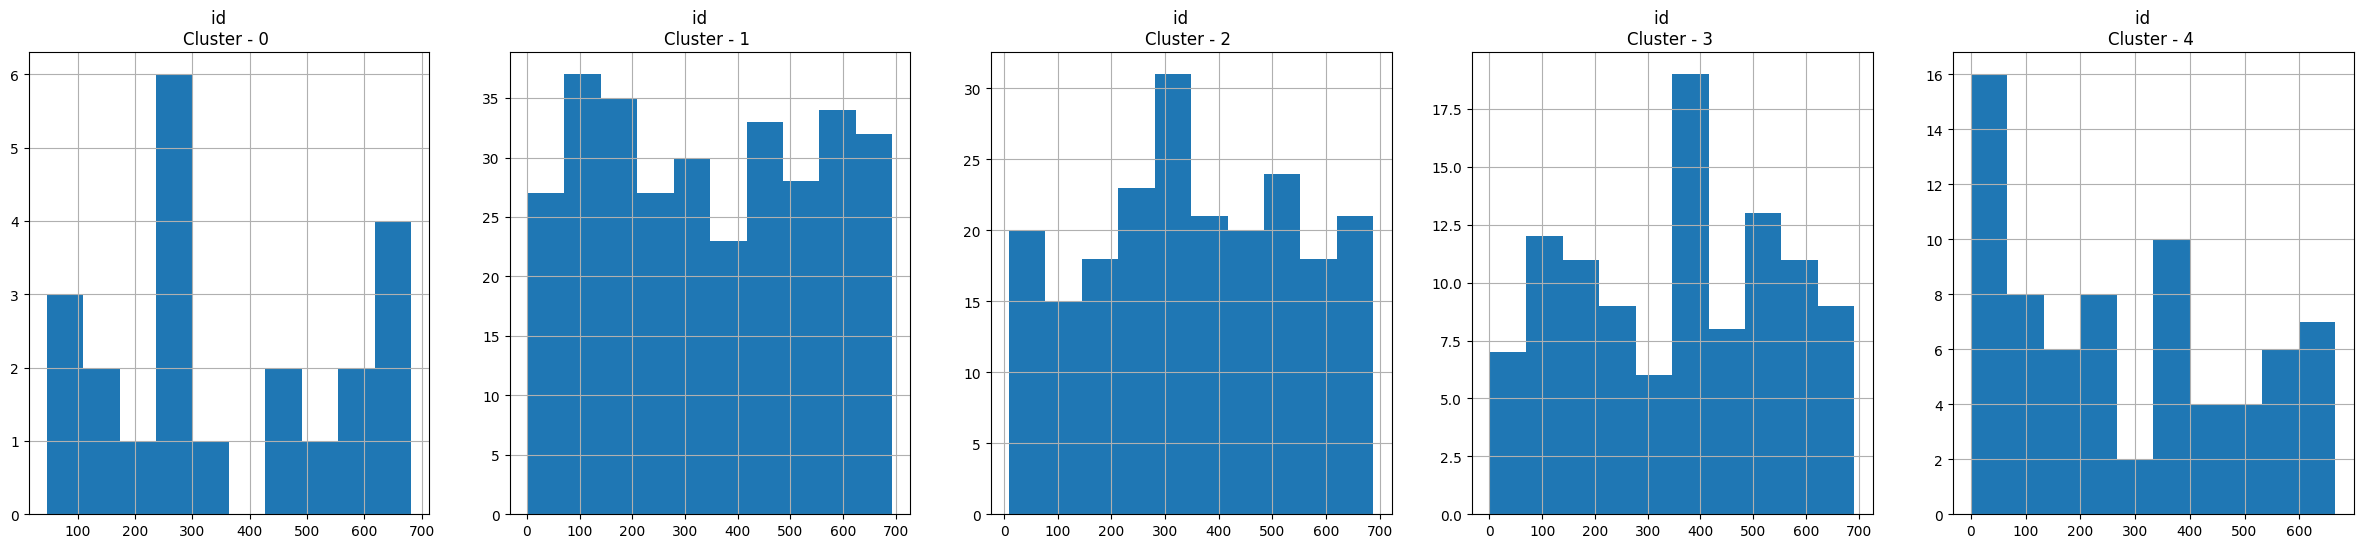

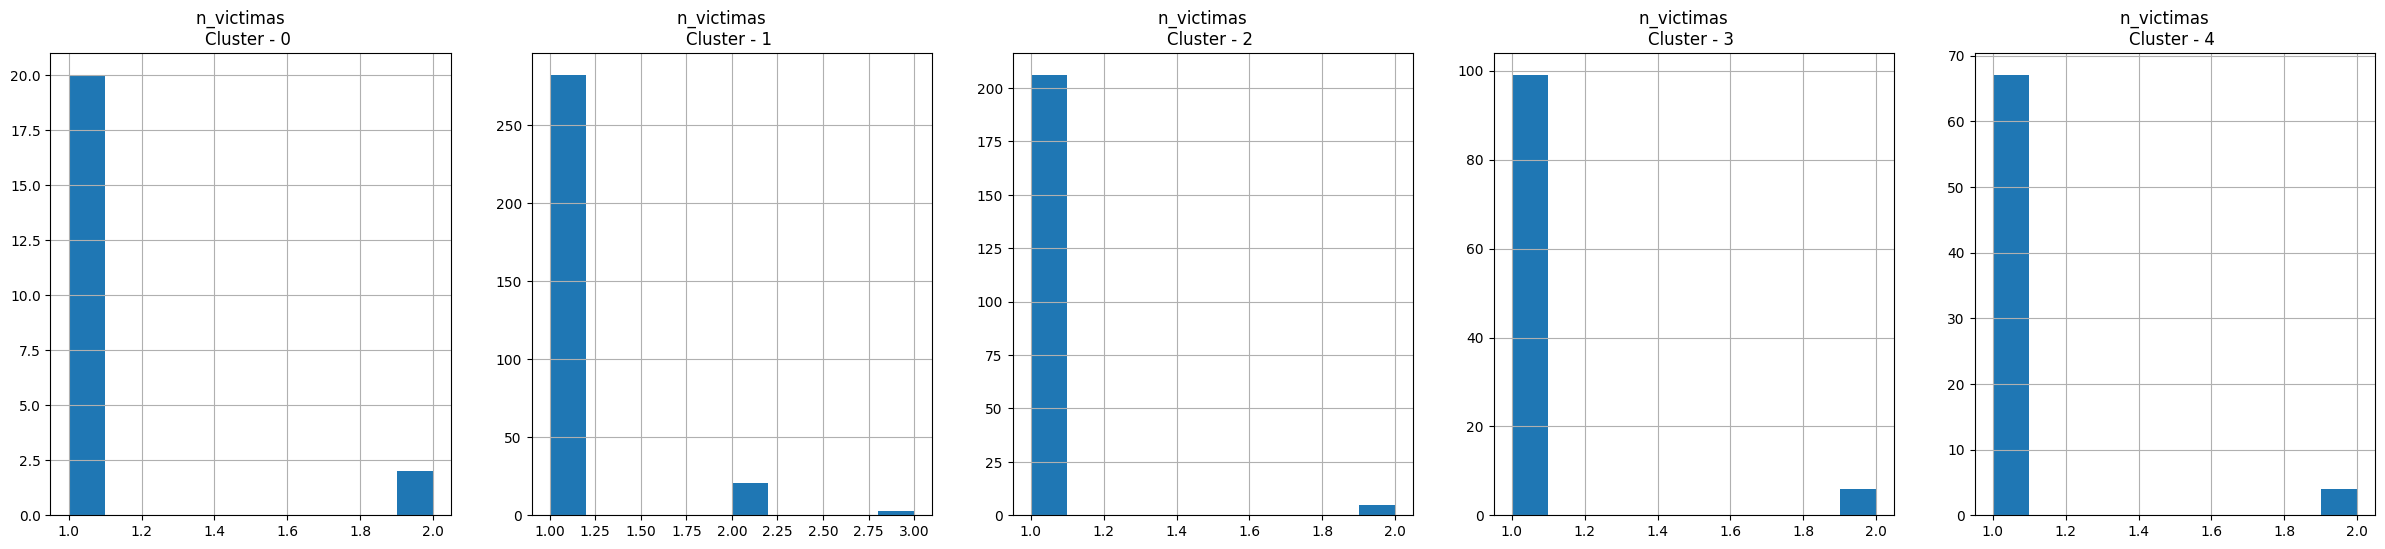

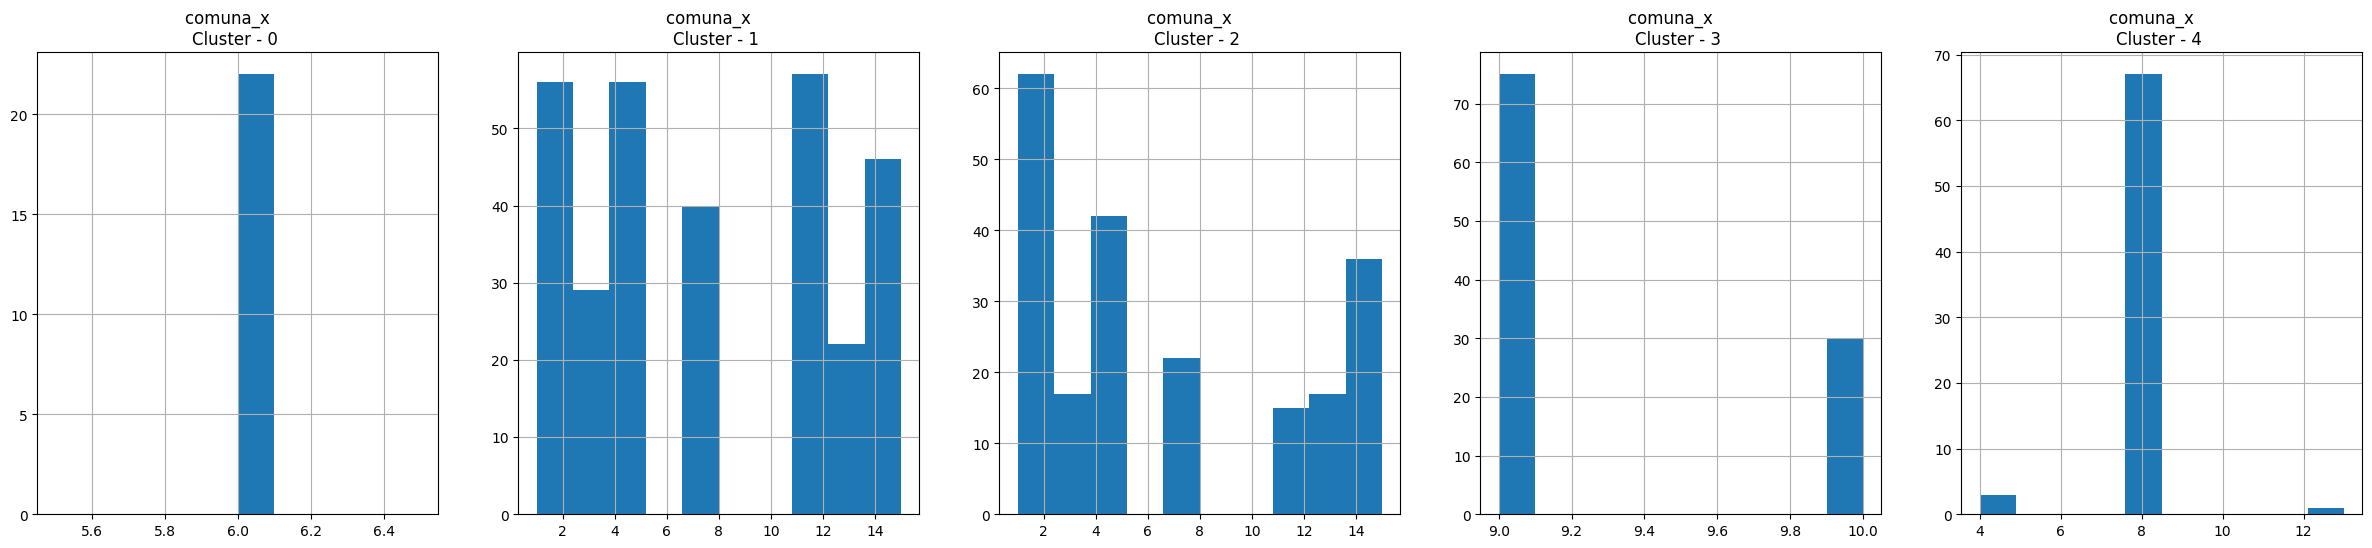

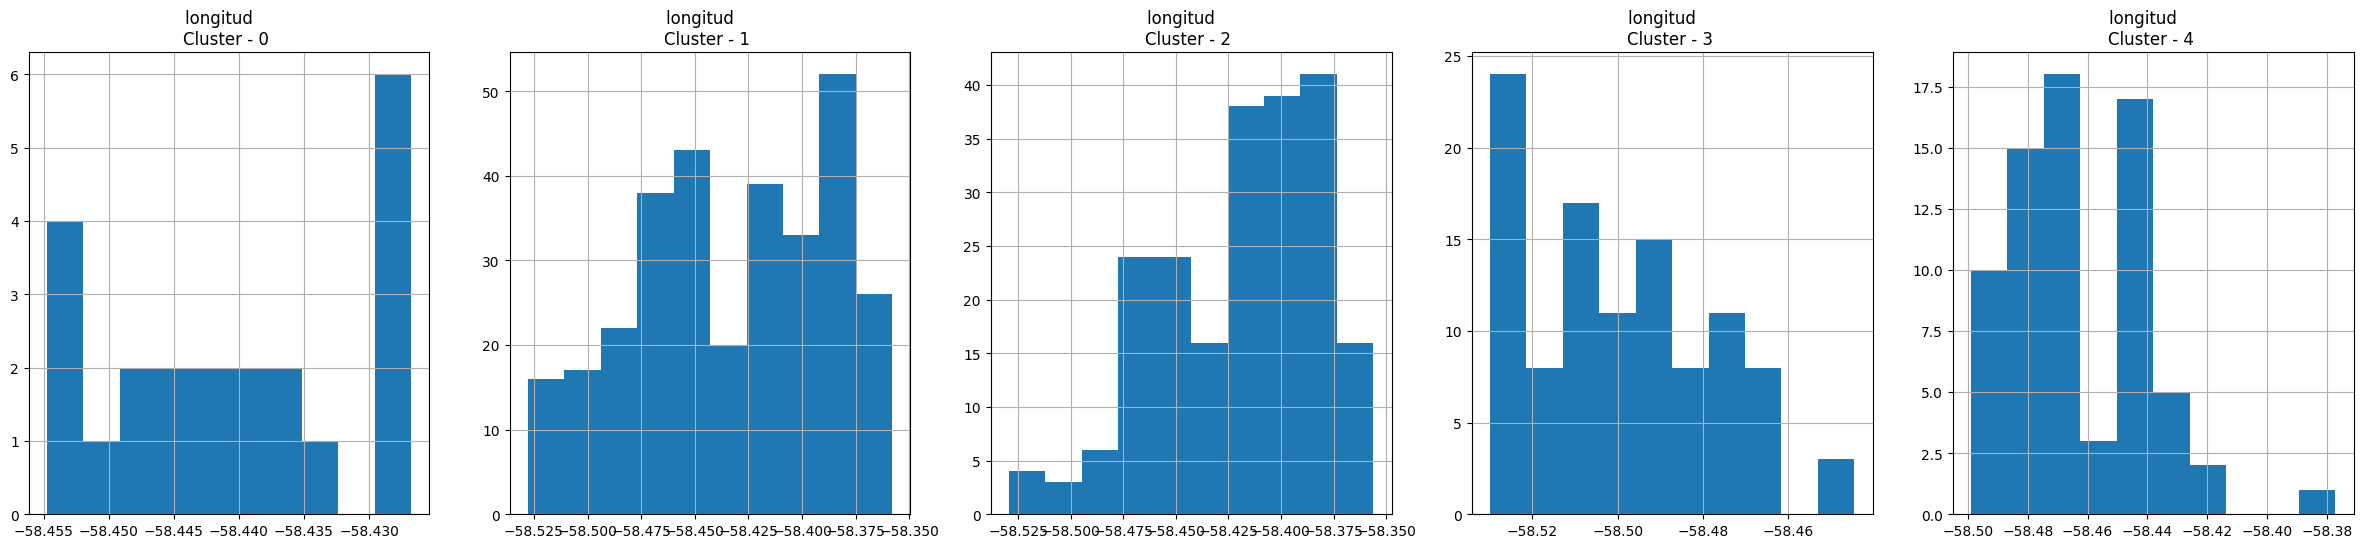

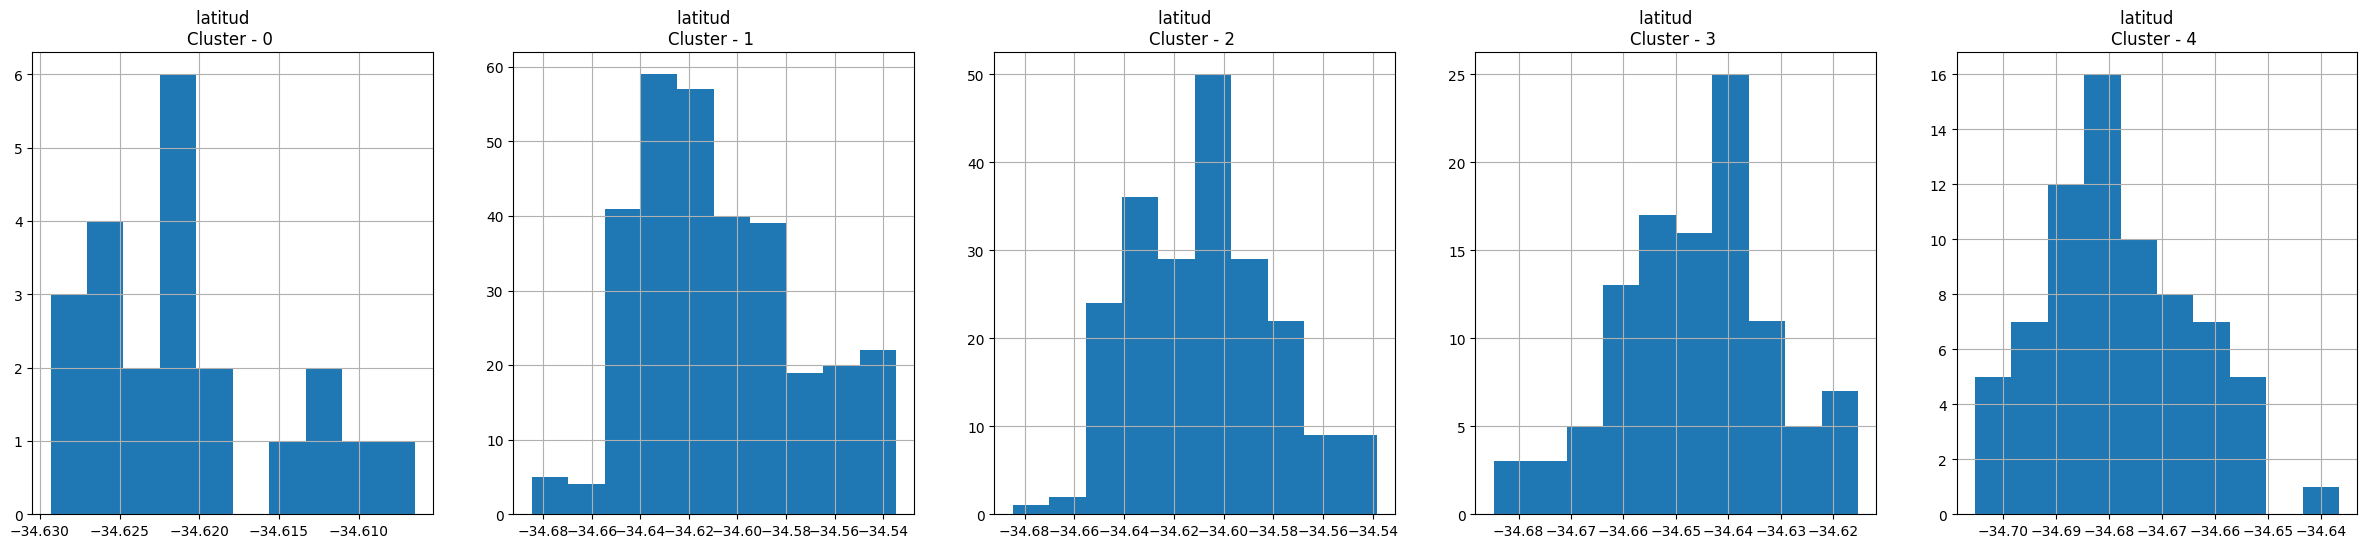

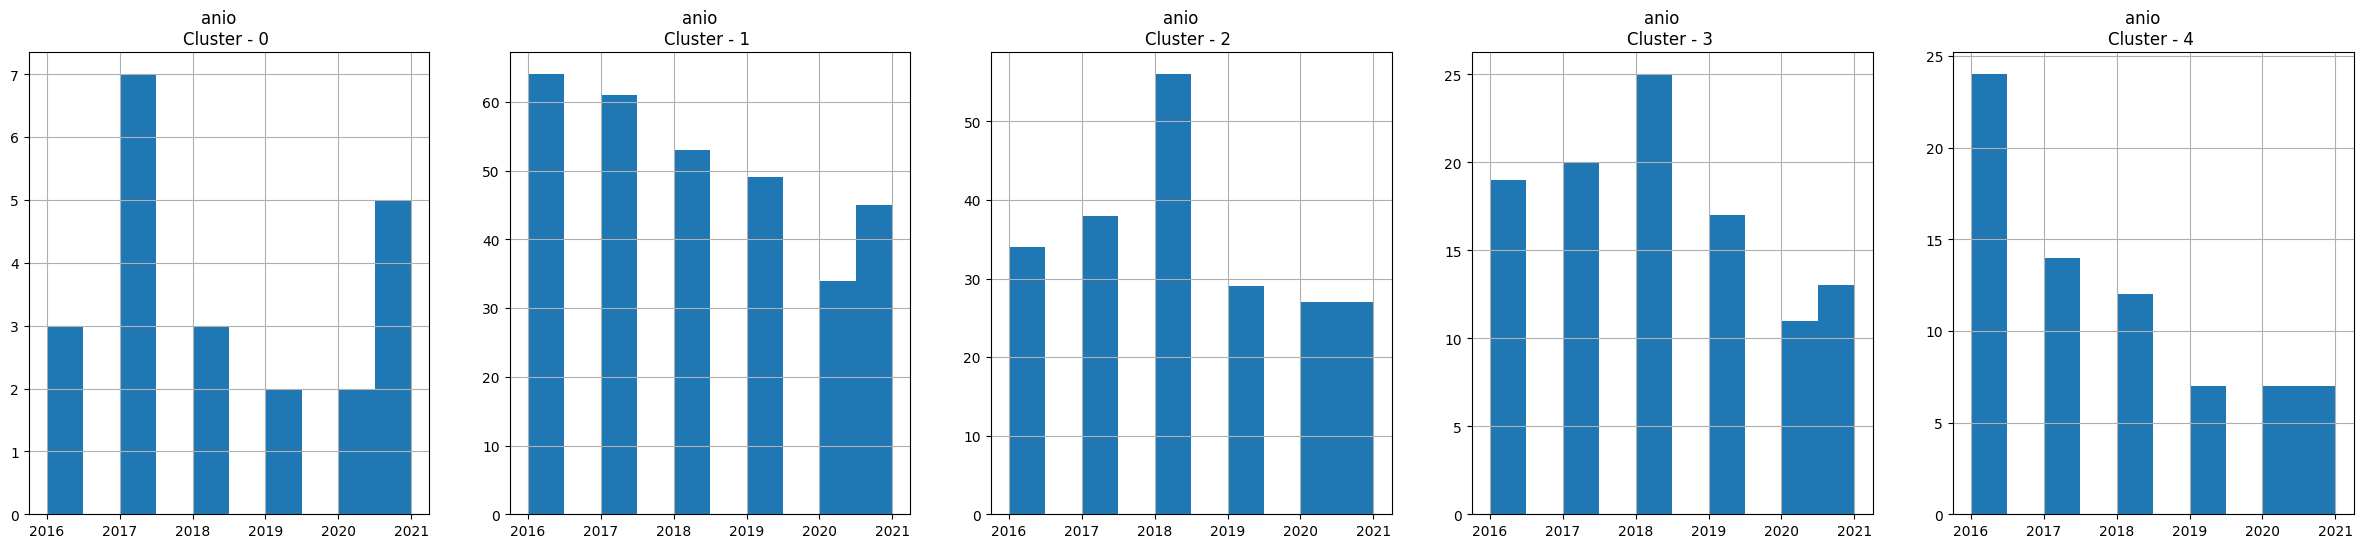

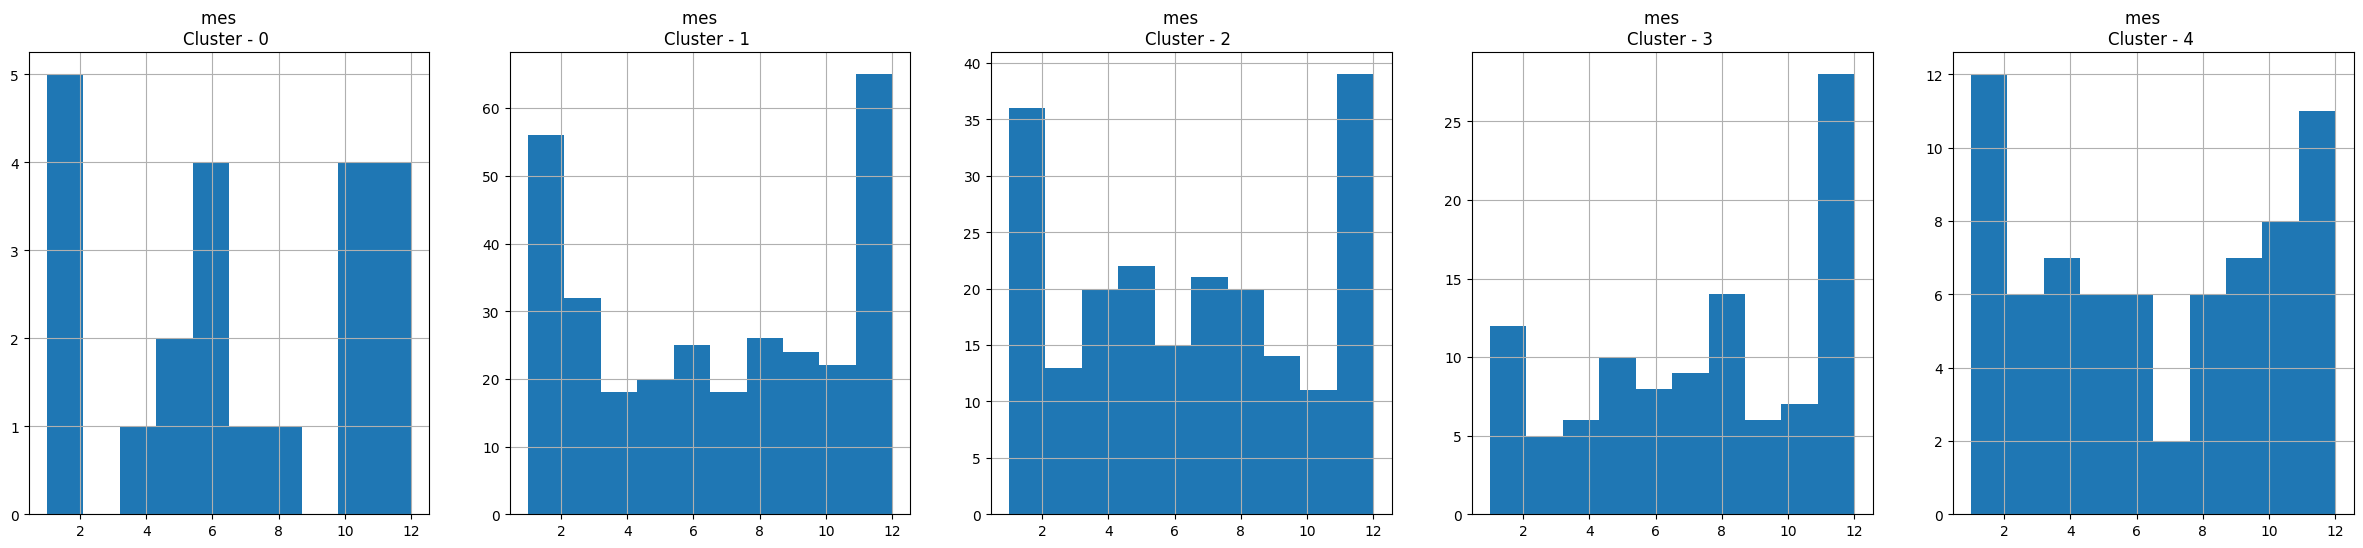

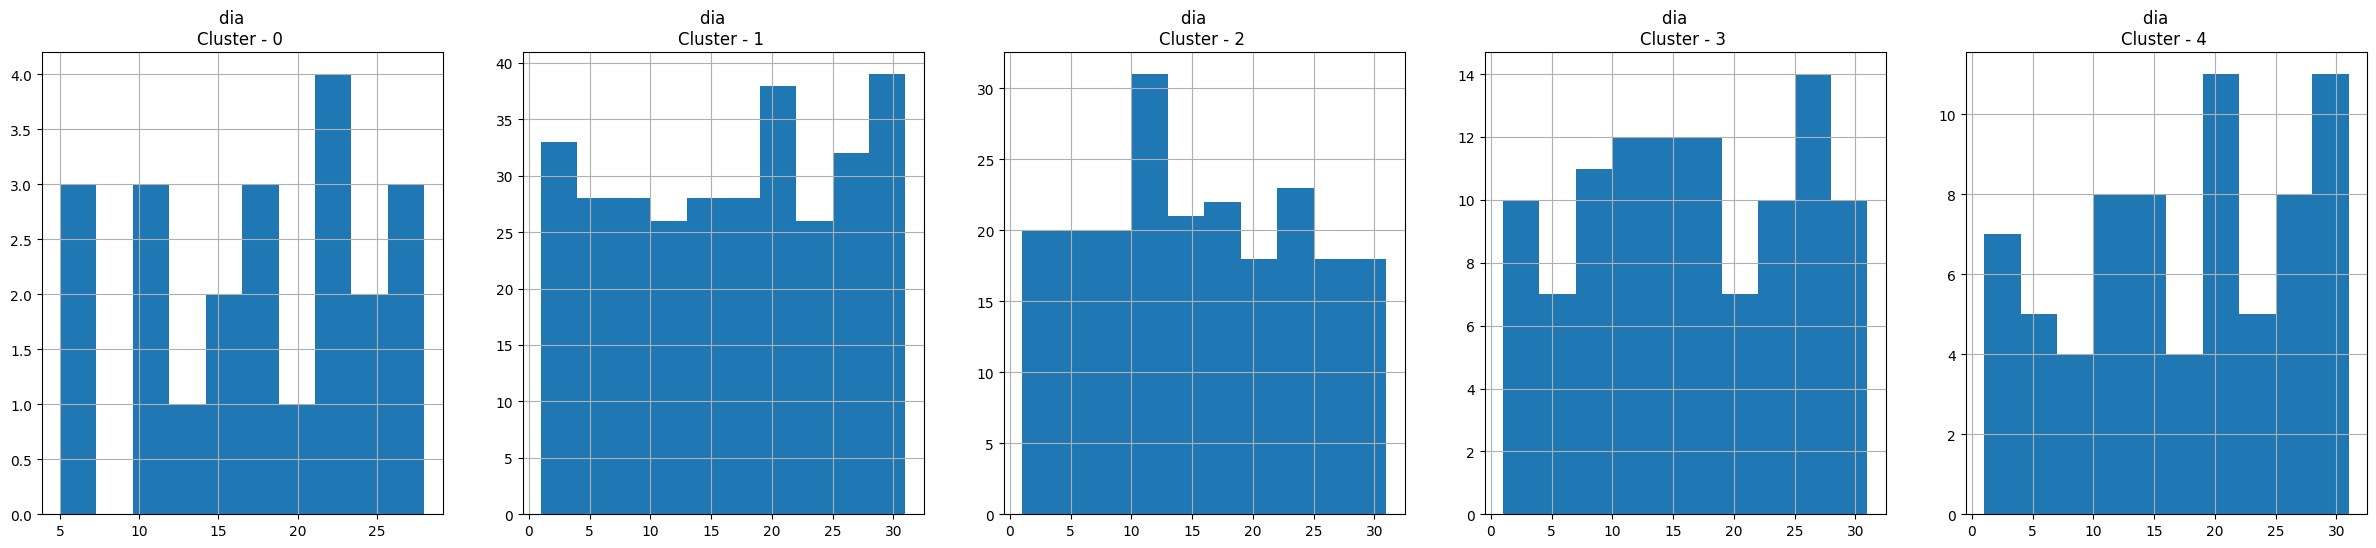

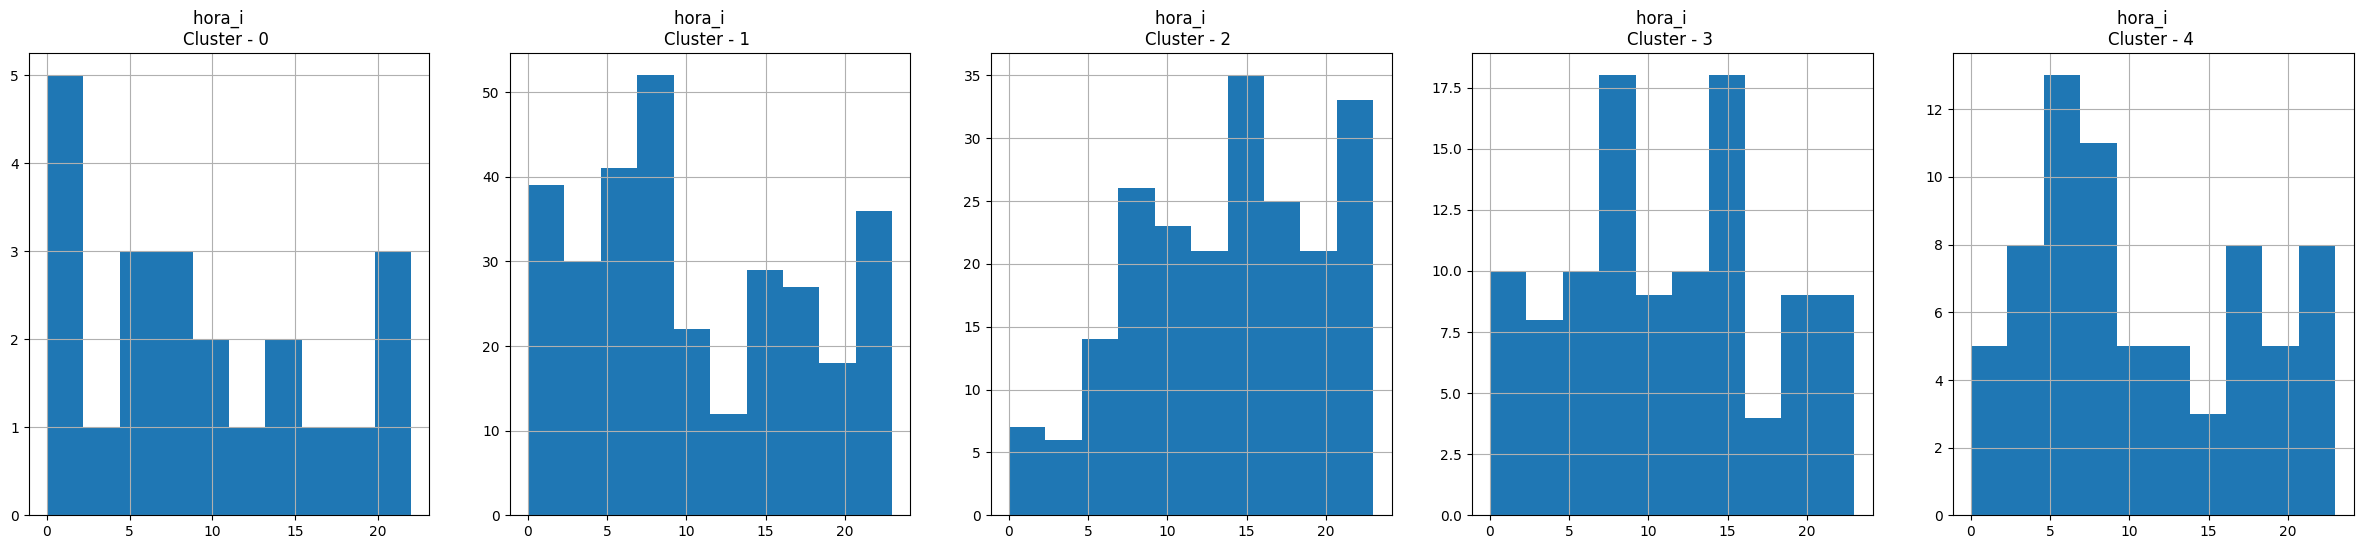

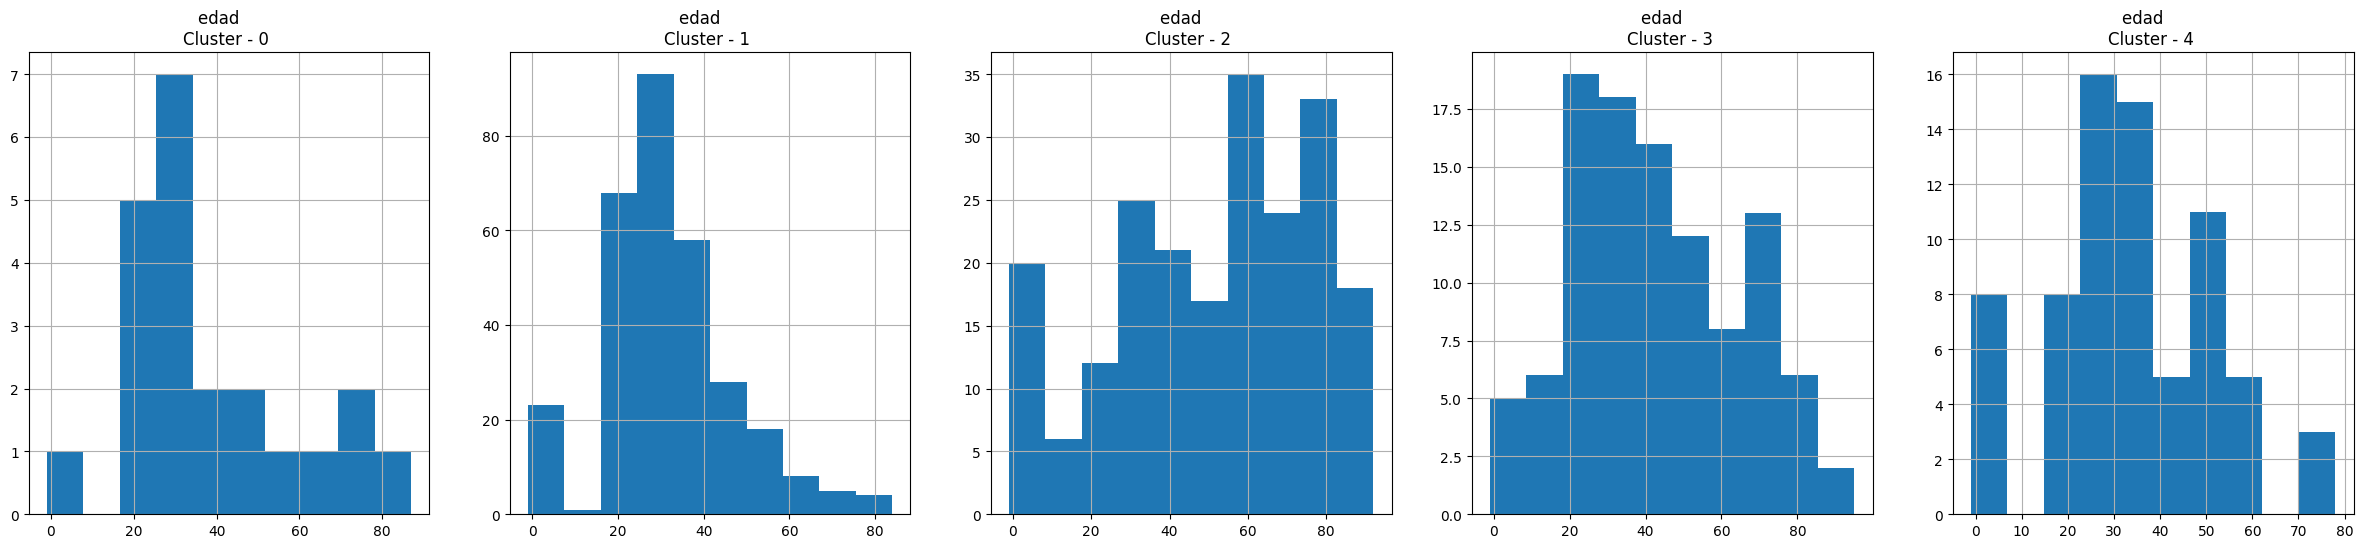

In [79]:
# Representar un histograma para cada característica según el clúster al que pertenece
for i in result_df.columns[:10]:
  plt.figure(figsize = (30, 6))
  for j in range(5):
    plt.subplot(1, 5, j+1)
    cluster = sale_df_cluster[sale_df_cluster['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))

  plt.show()

## Análisis de Componentes Principales y Vizualizar los datos

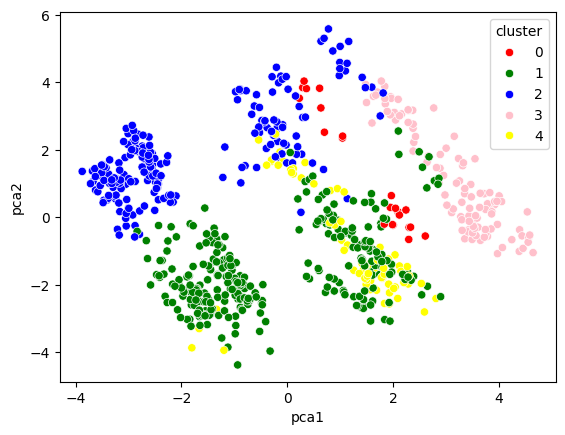

In [80]:
pca = PCA(n_components = 2)
principal_comp = pca.fit_transform(result_df_scaled)

pca_df = pd.DataFrame(data = principal_comp, columns = ['pca1', 'pca2'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)

ax = sns.scatterplot(x = "pca1", y = "pca2", hue = "cluster", data = pca_df, palette = ["red", "green", "blue", "pink", "yellow"])
plt.show()

# Otros

In [81]:
# Agrupar por año y mes, y sumar el número de víctimas
rel_tiempo = homicidios_lm.groupby(['anio', 'mes'])['n_victimas'].sum().reset_index()
# Combinar AÑO y MES para obtener una sola variable de tiempo, creando la columna "Fecha" como str
rel_tiempo["fecha"] = rel_tiempo["anio"].astype(str) + '-' + rel_tiempo["mes"].astype(str)
# Convertir la variable de tiempo a formato datetime
rel_tiempo["fecha"] = pd.to_datetime(rel_tiempo["fecha"])
rel_tiempo.head(5)

anio  mes  n_victimas      fecha
0  2016    1           8 2016-01-01
1  2016    2          12 2016-02-01
2  2016    3          13 2016-03-01
3  2016    4          11 2016-04-01
4  2016    5           7 2016-05-01

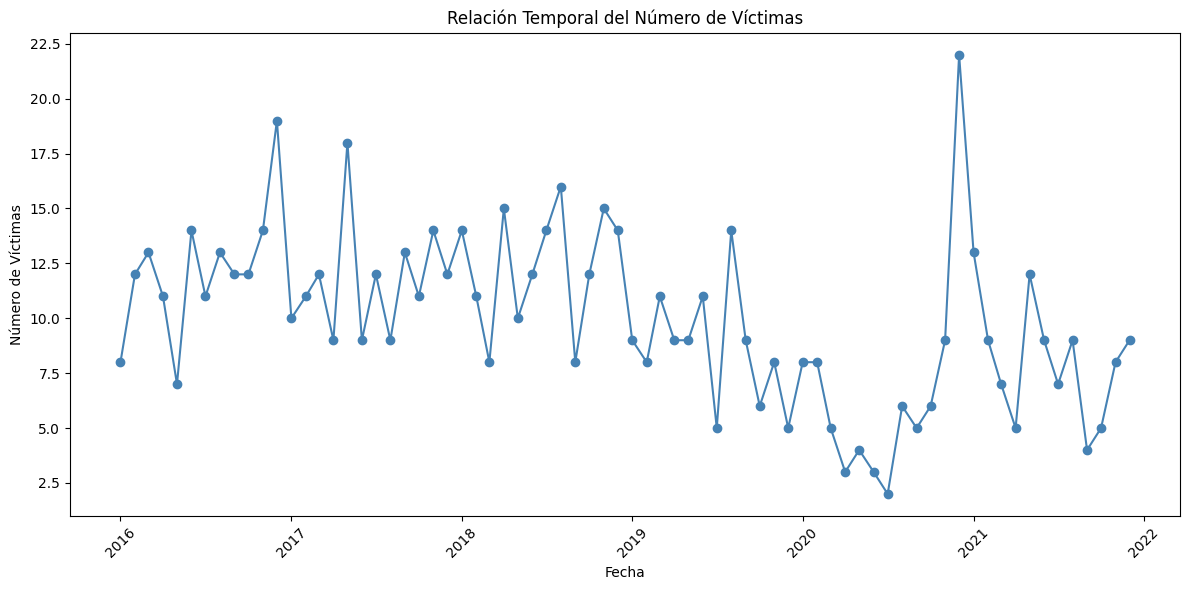

In [82]:
# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(rel_tiempo["fecha"], rel_tiempo["n_victimas"], marker='o', color='steelblue')

# Añadir títulos y etiquetas
plt.title('Relación Temporal del Número de Víctimas')
plt.xlabel('Fecha')
plt.ylabel('Número de Víctimas')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

C:\Users\ozi\AppData\Local\Temp\ipykernel_2624\3730978411.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




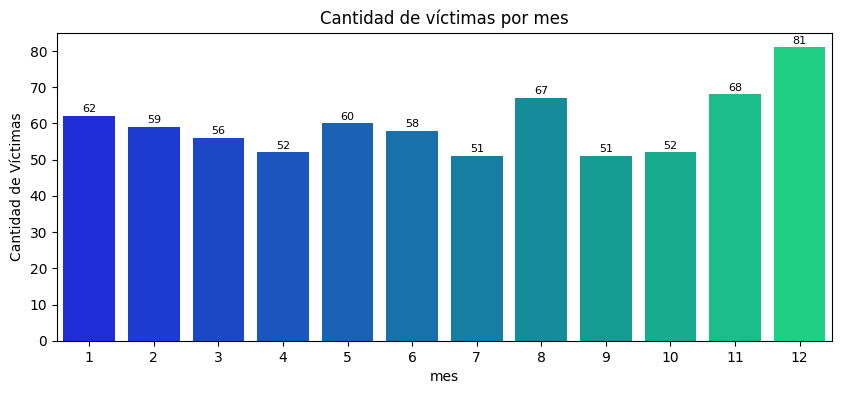

In [83]:
# Se agrupa por la cantidad de víctimas por mes
data = homicidios_lm.groupby(['mes'])['n_victimas'].sum().reset_index()
data["mes"]=data["mes"].astype("Int64")

# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='mes', y='n_victimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por mes')
ax.set_xlabel('mes') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

In [84]:
data.n_victimas.sum()


717

C:\Users\ozi\AppData\Local\Temp\ipykernel_2624\1403679157.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




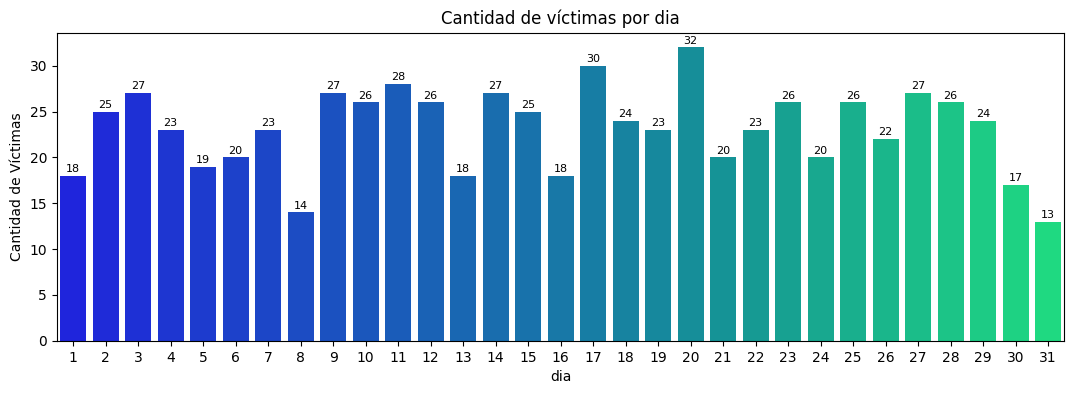

In [85]:
# Se agrupa por la cantidad de víctimas por dia
data = homicidios_lm.groupby(['dia'])['n_victimas'].sum().reset_index()
data["dia"]=data["dia"].astype("Int64")

# Se grafica
plt.figure(figsize=(13,4))

ax = sns.barplot(x='dia', y='n_victimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por dia')
ax.set_xlabel('dia') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

In [87]:
# Se agrupa por la cantidad de víctimas por fecha_formato
data = homicidios_l.groupby(['fecha_hora'])['n_victimas'].sum().reset_index()
#data["fecha_formato"]=data["fecha_formato"].astype("Int64")
#Creo una columna nueva `Día semana` que contenga el nombre del día de la semana
data['dia_sem'] = data['fecha_hora'].dt.strftime('%A')
#Creo un diccionario para modificar a español los nombres de los dás de la semana y lo aplico a la columna nueva
dic={  'Friday':'Viernes',
       'Saturday': 'Sabado',
       'Sunday': 'Domingo',  
       'Thursday': 'Jueves',
        'Monday': 'Lunes',
        'Wednesday': 'Miercoles',
       'Tuesday': 'Martes'}
data['dia_sem'] =data['dia_sem'].replace(dic)
# Eliminar columnas innecesarias
columns_to_drop = ['fecha_hora']
data = data.drop(columns=columns_to_drop)
data2 = data.groupby(['dia_sem'])['n_victimas'].sum().reset_index()


In [88]:
data2

dia_sem  n_victimas
0    Domingo         105
1     Jueves          96
2      Lunes         107
3     Martes         101
4  Miercoles          99
5     Sabado         107
6    Viernes         102

In [62]:
data.dia_sem.unique()

array(['Viernes', 'Sabado', 'Domingo', 'Jueves', 'Lunes', 'Miercoles',
       'Martes'], dtype=object)

C:\Users\ozi\AppData\Local\Temp\ipykernel_2624\1094173271.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




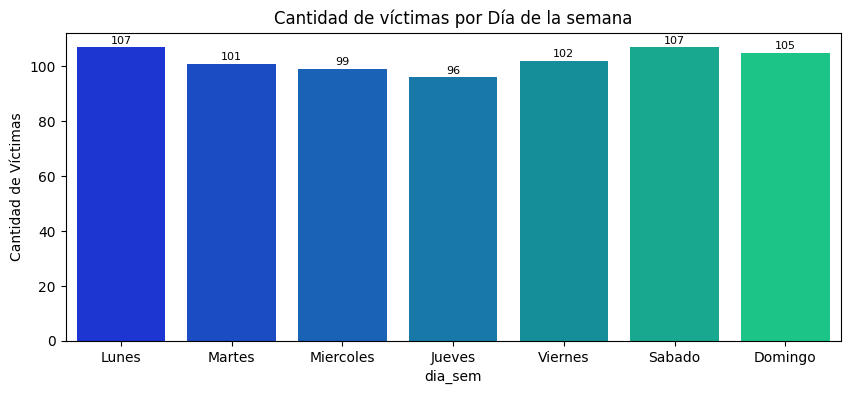

In [89]:
# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'orden_sem' en el DataFrame para representar el orden numérico de los días de la semana
data2['orden_sem'] = data2['dia_sem'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data2 = data2.sort_values(by='orden_sem')



# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='dia_sem', y='n_victimas', data=data2, palette="winter")
ax.set_title('Cantidad de víctimas por Día de la semana')
ax.set_xlabel('dia_sem') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico cambiar a semestre ? 
plt.show()

In [91]:
# Se agrupa por la cantidad de víctimas por fecha_formato
data = homicidios_l.groupby(['fecha_hora'])['n_victimas'].sum().reset_index()
#data["fecha_formato"]=data["fecha_formato"].astype("Int64")
#Creo una columna nueva `Día semana` que contenga el nombre del día de la semana
data['dia_sem'] = data['fecha_hora'].dt.strftime('%A')
data['hora'] = data['fecha_hora'].dt.hour

#Creo un diccionario para modificar a español los nombres de los dás de la semana y lo aplico a la columna nueva
dic={  'Friday':'Viernes',
       'Saturday': 'Sabado',
       'Sunday': 'Domingo',  
       'Thursday': 'Jueves',
        'Monday': 'Lunes',
        'Wednesday': 'Miercoles',
       'Tuesday': 'Martes'}
data['dia_sem'] =data['dia_sem'].replace(dic)
# Eliminar columnas innecesarias
columns_to_drop = ['fecha_hora']
data = data.drop(columns=columns_to_drop)
data2 = data.groupby(['dia_sem','hora'])['n_victimas'].sum().reset_index()


In [92]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dia_sem     162 non-null    object
 1   hora        162 non-null    int32 
 2   n_victimas  162 non-null    int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 3.3+ KB


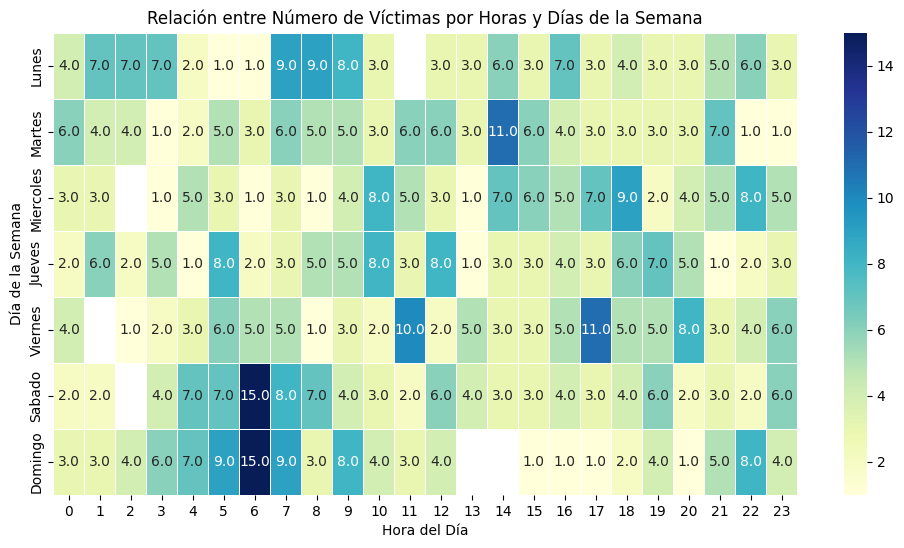

In [93]:
# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'orden_sem' en el DataFrame para representar el orden numérico de los días de la semana
data2['orden_sem'] = data2['dia_sem'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data2 = data2.sort_values(by='orden_sem')

# Crear una tabla pivot para los datos
pivot_data = data2.pivot_table(index= 'dia_sem', columns='hora', values='n_victimas', aggfunc='sum')
pivot_data = pivot_data.reindex(orden_dias_semana)

# Crear un mapa de calor (heatmap)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.1f', linewidths=0.5)

# Configurar etiquetas y título
plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.title('Relación entre Número de Víctimas por Horas y Días de la Semana')

# Mostrar el gráfico
plt.show()


In [94]:
import pandas as pd
import geopandas as gpd
import geojson
from shapely.geometry import Point, Polygon
from shapely.wkt import loads


c:\Users\ozi\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



<Axes: >

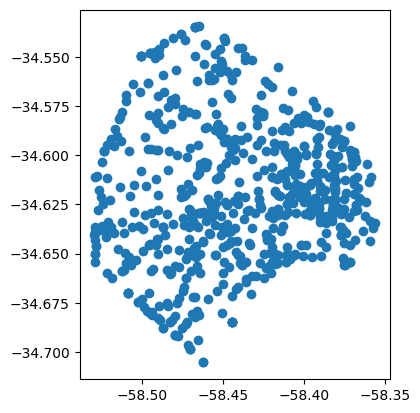

In [95]:
data_c = homicidios_lm.copy()
# Iniciamos CRS
crs={'init':'epsg:4326'}

#Definimos la geometría según nuestro dataset
geometry=[Point(xy) for xy in zip(data_c["longitud"], data_c["latitud"])]
#Ua vez que tenemos el sistema de referencia decoordenadas y la geometría; se procede a la carga de los datos
geodata=gpd.GeoDataFrame(data_c,crs=crs, geometry=geometry)

#Se imprime el resultante que luego será introducido en un mapa
geodata.plot()

In [97]:
# Convierte la columna WKT a geometrías
censo_r['geometry'] = censo_r['wkt'].apply(loads)
# Crea un GeoDataFrame
censo_gdf = gpd.GeoDataFrame(censo_r, geometry='geometry')

In [99]:
censo_r.columns

Index(['wkt', 'id', 'co_frac_ra', 'comuna', 'fraccion', 'radio', 'total_pob',
       't_varon', 't_mujer', 't_vivienda', 'v_particul', 'v_colectiv',
       't_hogar', 'h_con_nbi', 'h_sin_nbi', 'geometry'],
      dtype='object')

In [102]:
# Agrupar por la columna 'COMUNA' y sumar las columnas específicas
pol_comuna = censo_r.groupby('comuna')[['total_pob','t_varon', 't_mujer', 't_vivienda', 'v_particul', 'v_colectiv','t_hogar', 'h_con_nbi', 'h_sin_nbi']].sum()

# Mostrar el resultado
print(pol_comuna)

        total_pob  t_varon  t_mujer  t_vivienda  v_particul  v_colectiv  \
comuna                                                                    
1          205991    98160   107831      131396      130949         447   
2          157827    67979    89848      108122      107989         133   
3          187537    85601   101936      101436      101216         220   
4          218245   103166   115079       83033       82986          47   
5          179005    80806    98199       92903       92767         136   
6          176076    78870    97206       93481       93394          87   
7          220591   102481   118110       89688       89571         117   
8          187237    89545    97692       55427       55404          23   
9          161797    76207    85590       63414       63343          71   
10         166022    76972    89050       71664       71579          85   
11         189832    88469   101363       84734       84656          78   
12         200116    9252

Text(157.3143480453908, 0.5, 'Latitud')

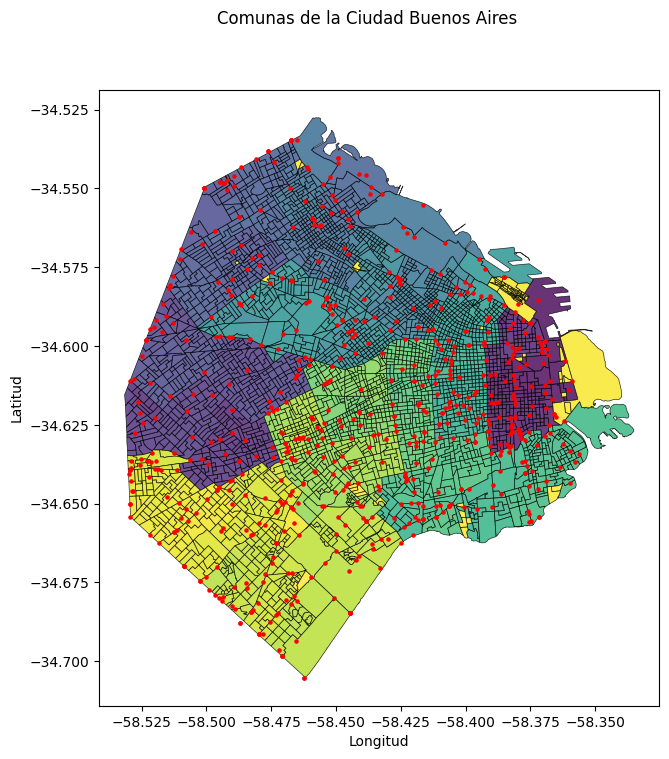

In [103]:
#Se realiza sobre el mapa de CABA la presentación de los puntos de referencia a los siniestros viales

#Crea ejes y figuras
fig, ax = plt.subplots(figsize=(10,8))

#Dibujar el Shapefile
censo_gdf.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=0.8,linewidth=0.5,cmap="viridis")

#Dibujar los datos geoespaciales
geodata.plot(ax=ax, color='red', markersize=5)

#Agregar título y etiquetas de ejes
fig.suptitle('Comunas de la Ciudad Buenos Aires', fontsize=12)
ax.set_xlabel('Longitud', fontsize=10)
ax.set_ylabel('Latitud', fontsize='medium')